# Covid Classification

## Descrizione del problema 

Il progetto ha l’obiettivo di implementare un sistema di classificazione di immagini di radiografie di pazienti sani, con covid o altre infezioni. Le classi indicheranno in particolare se un paziente sia affetto da covid o meno. 

L'analisi di radiografie con tecniche di Deep Learning è un approccio già ampiamente utilizzato in ambito medico. L'identificazione di Covid-19 attraverso Convolutional Neural Network può rappresentare un mezzo efficace per una prima lettura per la diagnosi stessa del virus e per il supporto alle decisioni dei medici.

## Dataset
https://www.kaggle.com/tawsifurrahman/covid19-radiography-database 

Suddiviso in COVID, Lung_Opacity, Normal, Viral Pneumonia. 

Cardinalità: 21200 di cui circa il 20% sono immagini etichettate come COVID. 

Dimensione: 740 MB.


## Import delle librerie

In [1]:
!pip install split-folders tqdm
!pip install tensorflow_addons
!pip install mlflow

     |████████████████████████████████| 679 kB 36.6 MB/s 
     |████████████████████████████████| 14.4 MB 61 kB/s 
     |████████████████████████████████| 1.1 MB 60.9 MB/s 
     |████████████████████████████████| 54 kB 3.8 MB/s 
     |████████████████████████████████| 636 kB 48.9 MB/s 
     |████████████████████████████████| 79 kB 9.3 MB/s 
     |████████████████████████████████| 146 kB 79.3 MB/s 
     |████████████████████████████████| 170 kB 74.3 MB/s 
     |████████████████████████████████| 75 kB 4.4 MB/s 
     |████████████████████████████████| 68 kB 8.1 MB/s 
     |████████████████████████████████| 63 kB 2.3 MB/s 
  Created wheel for alembic: filename=alembic-1.4.1-py2.py3-none-any.whl size=158170 sha256=777c58e6c33ada3ab6d8697b685a8922d736780db0ed7c704962c147d0f5cc0f
  Stored in directory: /root/.cache/pip/wheels/be/5d/0a/9e13f53f4f5dfb67cd8d245bb7cdffe12f135846f491a283e3
  Created wheel for databricks-cli: filename=databricks_cli-0.14.3-py3-none-any.whl size=100557 sha256=695b51

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from tensorflow import keras
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.keras import optimizers
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from datetime import datetime
import random
from mpl_toolkits.axes_grid1 import ImageGrid
from tensorflow.keras import layers
from sklearn.metrics import confusion_matrix, classification_report
import splitfolders
import os
import shutil
import IPython
import mlflow
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mat_image

## Tracking e log degli esperimenti

A supporto dei molteplici esperimenti fatti si è utilizzato [MLFlow](https://mlflow.org); questo tool permette di effettuare il log degli esperimenti di un progetto di Machine Learning (in generale). MLFlow è stato utilizzato, in questo progetto, per tenere traccia degli iperparametri utilizzati e delle metriche ottenute.

Nel codice dell'addestramento delle architetture si sono utilizzati i metodi mlflow.start_run(), mlflow.set_tag(), mlflow.tensorflow.autolog() e mlflow.end_run(). Le celle di codice sono state lasciate per mostrare come è stato fatto il log degli esperimenti, queste, però, sono commentate in quanto utilizzate solo per gli addestramenti.

La cella di codice seguente imposta l'uri del server nel quale sono stati salvati i log degli esperimenti e, l'ultima riga, mostra gli esperimenti fatti.

In [ ]:
REPO_NAME= "dl-project"
USER_NAME = "esalvucci"
os.environ['MLFLOW_TRACKING_USERNAME'] = 'esalvucci'
os.environ['MLFLOW_TRACKING_PASSWORD'] = 'c797c82f6b341e84671f23233ace1797e7a78d50'

mlflow.set_tracking_uri(f'https://dagshub.com/{USER_NAME}/{REPO_NAME}.mlflow')
display(IPython.display.IFrame(f"https://dagshub.com/{USER_NAME}/{REPO_NAME}/experiments/#/",'100%',600))

## Import dei dati

In [4]:
zipped_dataset_path = "/content/dataset.zip" 
path_to_downloaded_file = tf.keras.utils.get_file(
    "/content/dataset.zip",
    "https://cerimoniale.net/sito/uploads/2021/05/dl-project/archive.zip")

dataset_path = '/content/COVID-19_Radiography_Dataset'
!unzip /content/dataset.zip

os.remove(zipped_dataset_path)

Streaming output truncated to the last 5000 lines.
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6710.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6711.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6712.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6713.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6714.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6715.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6716.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6717.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6718.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6719.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-672.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6720.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6721.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6722.png  
  inflating:

## Utility functions

In [5]:
def plot_history(history,metric=None):
  """
  Draws in a graph the loss trend over epochs on both training and validation
  sets. Moreover, if provided, it draws in the same graph also the trend of
  the given metric. 

  :param history: A History object. Its 'history' attribute is a record
      of training loss values ('loss') and metrics values at successive epochs,
      as well as validation loss values ('val_loss') and validation metrics
      values (if applicable).
  :param metric: The name of the plotted metric.
  """
  fig, ax1 = plt.subplots(figsize=(10, 8))

  epoch_count=len(history.history['loss'])

  line1,=ax1.plot(range(1,epoch_count+1),history.history['loss'],label='train_loss',color='orange')
  ax1.plot(range(1,epoch_count+1),history.history['val_loss'],label='val_loss',color = line1.get_color(), linestyle = '--')
  ax1.set_ylim([0, max(max(history.history['loss']),max(history.history['val_loss']))])
  ax1.set_ylabel('loss',color = line1.get_color())
  ax1.tick_params(axis='y', labelcolor=line1.get_color())
  _=ax1.legend(loc='lower left')

  if (metric!=None):
    ax2 = ax1.twinx()
    line2,=ax2.plot(range(1,epoch_count+1),history.history[metric],label='train_'+metric)
    ax2.plot(range(1,epoch_count+1),history.history['val_'+metric],label='val_'+metric,color = line2.get_color(), linestyle = '--')
    ax2.set_xlim([1,epoch_count])
    ax2.set_ylim([0, max(max(history.history[metric]),max(history.history['val_'+metric]))])
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel(metric,color=line2.get_color())
    ax2.tick_params(axis='y', labelcolor=line2.get_color())
    _=ax2.legend(loc='upper right')

  fig.savefig(metric + '_history.png')


def save_model(model, name, extension='h5'):
  """
  Saves a trained model to be used in the future for a further training.
  :param model: The model to be saved (trained by Keras).
  :param name: The name of the model.
  """
  model.save(name + '.' + extension)


def load_model(path):
  """
  Loads a model in such a way that its training can go on.
  :param path: The path of the model to be loaded.

  :return: The Keras model
  """
  return keras.models.load_model(path) 


def show_images_grid(image_list,nrows,ncols,label_list=None,show_labels=False,savename=None,figsize=(10,10),showaxis='off'): 
    if type(image_list) is not list:
        if(image_list.shape[-1]==1):
            image_list = [image_list[i,:,:,0] for i in range(image_list.shape[0])]
        elif(image_list.shape[-1]==3):
            image_list = [image_list[i,:,:,:] for i in range(image_list.shape[0])]
    fig = plt.figure(None, figsize,frameon=False)
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(nrows, ncols),  # creates 2x2 grid of axes
                     axes_pad=0.3,  # pad between axes in inch.
                     share_all=True,
                     )
    for i in range(nrows*ncols):
        ax = grid[i]
        ax.imshow(image_list[i],cmap='Greys_r')  # The AxesGrid object work as a list of axes.
        ax.axis('off')
        if show_labels:
            ax.set_title(class_names[label_list[i].nonzero()[0][0]])
    if savename != None:
        plt.savefig(savename,bbox_inches='tight')


def get_next_minibatch(dataset_iterator):
  """
  Get the next minibatch of the dataset iterator, splitted into (images, labels)
  :param dataset_iterator: The iterator of the dataset (training_set_iterator, 
  test_set_iterator or validation_set_iterator)
  :return : The minibatch in the form of (images, labels)
  """
  mini_batch = dataset_iterator.next()
  
  images = mini_batch[0]
  labels = mini_batch[1]
  return images, labels


def get_classes_cardinality(iterator, percentage = False):
  """
  Count the number of images for each class in the given iterator
  :return: An array containing the cardinality of each class
  """
  labels = iterator.classes

  covid_images_number = np.count_nonzero(labels == 0)
  lung_opacity_images_number = np.count_nonzero(labels == 1)
  normal_images_number = np.count_nonzero(labels == 2)
  viral_pneumonia_images_number = np.count_nonzero(labels == 3)

  if percentage:
    return [get_percentage(len(labels), covid_images_number),
            get_percentage(len(labels), lung_opacity_images_number),
            get_percentage(len(labels), normal_images_number),
            get_percentage(len(labels), viral_pneumonia_images_number)]
  else:
    return [covid_images_number,
            lung_opacity_images_number,
            normal_images_number,
            viral_pneumonia_images_number]


def get_percentage(total, count):
  return (100 * count) / total


def print_classes_cardinality(iterator, percentage=False):
  """
  Prints the cardinality of each class in the given iterator
  """
  cardinalities = get_classes_cardinality(iterator, percentage)
  labels = list(iterator.class_indices.keys())

  print('Total {:d}, Covid: {:d}, Lung Opacity: {:d}, Normal: {:d}, \
        Viral Pneumonia: {:d}'.format(len(labels), cardinalities[0],
                                    cardinalities[1],
                                    cardinalities[2],
                                    cardinalities[3]))
  

def plot_classes_cardinality(iterator):
  fig, ax = plt.subplots()
  
  labels = list(iterator.class_indices.keys())

  percentages = get_classes_cardinality(iterator, percentage=True)

  ax.pie(percentages, labels=labels,  
         autopct='%1.0f%%', 
         shadow=False, startangle=0,   
         pctdistance=1.2,labeldistance=1.4)
  ax.axis('equal')
  ax.set_title("Classes distribution")
  ax.legend(frameon=False, bbox_to_anchor=(1.5,0.8))


def get_indexes_of_misclassified_images(iterator, predictions):
  """
  Filters the predictions which are different than the actual classes.
  :param iterator: The iterator containing the actual classes.
  :param predictions: The predictions to be compared to the actual classes.
  :returns: An array containing the indexes of the misclassified items.
  """

  return np.where(predictions != iterator.classes)[0]


def get_misclassified_images(iterator, predictions, base_path = '/content/splitted_dataset/test/'):
  """
  From the misclassified items builds three arrays: one containing the images,
  one containing the actual labels and, the last, with the predicted classes.
  :param iterator: The iterator to get the actual labels from.
  :param predictions: An array containing the model predictions.
  :param base_path: The base path of the images, to be joined with the file names.
  :return images: The misclassified images.
  :return actual_labels: The actual labels of the misclassified images.
  :retur predicted_labels: The labels, predicted by the model, of the misclassified images.
  """
  images = []
  predicted_labels = []
  actual_labels = []
  misclassified_files_indexes = get_indexes_of_misclassified_images(iterator, predictions)

  for i in misclassified_files_indexes:
      actual_labels.append(iterator.classes[i])
      predicted_labels.append(predictions[i])
      images.append(mat_image.imread(os.path.join(base_path, iterator.filenames[i])))
  return images, actual_labels, predicted_labels


def plot_misclassified_images(iterator, predictions, rows = 5, columns = 4, fig_size = (50, 50)):
  """
  Plot the misclassified images
  :param iterator: The iterator to get the images from.
  :param predictions: An array containing the model predictions.
  :param rows: The number of rows of the plot.
  :param colums: The number of colums of the plot.
  :param fig_size: The size of the figures in the plot.
  """
  %matplotlib inline

  matplotlib.rcParams.update({'font.size': 30})

  figure = plt.figure(figsize=fig_size)
  images, actual_labels, predicted_labels = get_misclassified_images(test_set_iterator, predictions)  

  for i in range(1, columns*rows +1):
    random_index = np.random.choice(range(len(images)))  
    ax = figure.add_subplot(rows, columns, i)
    ax.set_title('Actual: ' + class_names[actual_labels[random_index]] + '\nPredicted: ' + class_names[predicted_labels[random_index]])
    plt.axis('off')
    plt.imshow(images[random_index])
  plt.show()


## Split del dataset

La classe ImageDataGenerator permette di generare mini-batch di immagini; la classe può essere utilizzata anche per il preprocessing delle immagini (ed, eventualmente, anche fare data augmentation): attraverso ImageDataGenerator qui viene scalata l'intensità dei pixel in modo che sia questa rientri in un range [0, 1] invece che [0, 255] (in modo da evitare che valori elevati rendano l'addestramento instabile).

Nella funzione split_dataset(), oltre ad instanziare un ImageDataGenerator, viene suddiviso il dataset in *training set*, *validation set* e *test set*.
La funzione prende come parametro target_size, la dimensione da impostare per le immagini. Tutte le reti (ad eccezione della InceptionV4), nelle loro architetture originali, prendono in input immagini (224, 224, 3); in questo caso si è scelto di utilizzare dimensioni (224, 224, 1): le reti sono addestrate da zero e, utilizzare 1 come valore per la *depth*, ci permette di ridurre il numero di pesi addestrabili.

La libreria *splitfolder* permette di partizionare una directory in sotto cartelle; in questo caso la directory del dataset originale viene suddivisa in

* /content/splitted_dataset/
  * train
    * COVID
    * Lung_Opacity
    * Pneumonia
    * Normal
  * test
    * COVID
    * Lung_Opacity
    * Pneumonia
    * Normal

Il validation set viene estratto dalla directory *train* come porzione della stessa specificando il parametro *subset='validation'* della funzione *flow_from_directory* della classe *ImageDataGenerator*

In [6]:
def split_dataset(batch_size=32,
                  target_size=(224, 224),
                  training_set_size=0.8,
                  test_set_size=0.2,
                  validation_set_size=0.25,
                  color_mode="grayscale"):

  splitted_dataset_path = '/content/splitted_dataset'
  if os.path.isdir(splitted_dataset_path):
      shutil.rmtree(splitted_dataset_path)

  datagenerator = ImageDataGenerator(validation_split = validation_set_size,
                                    rescale=1./255)

  os.mkdir(splitted_dataset_path)
  splitfolders.ratio(dataset_path,
                     output=splitted_dataset_path,
                     seed=1337,
                     ratio=(training_set_size, test_set_size),
                     group_prefix=None)
  os.rename(splitted_dataset_path + '/val', splitted_dataset_path + '/test')
  
  training_set_iterator = datagenerator.flow_from_directory(
      splitted_dataset_path + '/train',
      target_size=target_size,
      color_mode=color_mode,
      classes=None,
      class_mode="categorical",
      batch_size=batch_size, 
      shuffle=True,
      seed=None,
      subset='training',
  )

  validation_set_iterator = datagenerator.flow_from_directory(
      splitted_dataset_path + '/train',
      target_size=target_size,
      color_mode=color_mode,
      classes=None,
      class_mode="categorical",
      batch_size=batch_size,
      shuffle=True,
      seed=None,
      subset='validation',
  )

  test_set_iterator = datagenerator.flow_from_directory(
      splitted_dataset_path + '/test',
      target_size=target_size,
      color_mode=color_mode,
      classes=None,
      class_mode="categorical",
      batch_size=batch_size,
      shuffle=False,
      seed=None
  )

#  shutil.rmtree(dataset_path)

  return training_set_iterator, validation_set_iterator, test_set_iterator

In [7]:
target_size=(224, 224, 1)
training_set_iterator, validation_set_iterator, test_set_iterator = split_dataset()

Copying files: 21165 files [00:04, 5256.02 files/s]


Found 12698 images belonging to 4 classes.
Found 4232 images belonging to 4 classes.
Found 4235 images belonging to 4 classes.


## Immagini di esempio

Attraverso le celle seguenti vengono mostrate delle immagini di esempio di un mini-batch ottenuto casualmente dal training set.

In [ ]:
class_names = list(training_set_iterator.class_indices.keys())
class_count = training_set_iterator.num_classes

In [ ]:
minibatch_images, minibatch_labels = get_next_minibatch(training_set_iterator)
print('Class names: ', class_names)
print('Batch shape=%s, min=%.3f, max=%.3f' %
      (minibatch_images.shape, minibatch_images.min(), minibatch_images.max()))

In [ ]:
show_images_grid(minibatch_images,4,8,label_list=minibatch_labels,show_labels=True,figsize=(20,10))

## Classificazione

Il task di classificazione è stato implementato sperimentando diverse architetture nelle loro varianti più utilizzate in letteratura in ambito classificazione di radiografie Covid-19.
Le architetture implementate sono 

* VGG
* ResNet
* Inception

**Nella sezione relativa all'analisi delle prestazioni si forniscono i modelli già addestrati in quanto l'addestramento richiede molto tempo.**

#### Metriche utilizzate

Eseguendo la cella seguente si può notare come il dataset sia sbilanciato (il grafico mostra la percentuale di immagini per ogni classe nel training set).



Total 4, Covid: 2169, Lung Opacity: 3607, Normal: 6115,         Viral Pneumonia: 807


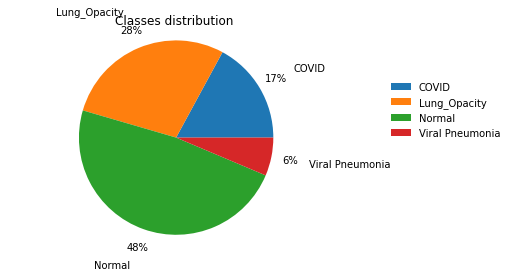

In [8]:
print_classes_cardinality(training_set_iterator)
plot_classes_cardinality(training_set_iterator)

La sola accuracy può essere problematica per misurare le prestazioni di un problema di classificazione su un dataset sbilanciato in quanto non è una metrica efficace per predire classi "non comuni" e più rare di altre.
Nell'affrontare un problema di classificazione è rilevante invece misurare gli errori commessi dal classificatore: Falsi Positivi o Falsi Negativi.

Per questo motivo si sono utilizzate, oltre all'accuracy, altre metriche:

* Accuracy
* Precision
* Recall
* F1-Score
* AUC-ROC
* Confusion Matrix

In [9]:
metrics=[
  tf.keras.metrics.AUC(name='auc'),
  tfa.metrics.F1Score(num_classes=class_count, average='weighted', threshold=0.5),
  tf.keras.metrics.Precision(name='precision'),
  tf.keras.metrics.Recall(name='recall'),
  'accuracy'
]

NameError: ignored

---

* **Accuracy**

  La metrica Accuracy indica la frazione delle predictions che il modello ha classificato correttamente

  accuracy = (numero di predictions corrette) / (numero totale di predictions)

* **Precision e recall**

  Precision da un'idea della quantità di elementi classificati correttamente, con una certa classe, rispetto al totale degli item classificati con quella stessa classe (TP+FP). Recall, invece, indica la quantità di elementi classificati correttamente rispetto alla quantità

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/2/26/Precisionrecall.svg/800px-Precisionrecall.svg.png" alt="Precision and Recall" width="320"/>

* **F1-Score**

  F1-Score è una misura che combina Precision e Recall e viene calcolata come media armonica delle due metriche.

  Con F1-Score si vuole ottenere un bilanciamento equilibrato tra precision e recall, situazione particolarmente utile quando si ha un dataset sbilanciato (con una distribuzione delle classi che non è uniforme). [[1](https://sebastianraschka.com/faq/docs/computing-the-f1-score.html)]

  f1-score = 2 \* ((precision \* recall)/(precision + recall))

* **AUC-ROC**

  La metrica AUC-ROC è molto utile per misurare l’accuratezza dei test diagnostici, il cui risultato è una variabile continua. Si basa sul calcolo della curva ROC e sulla soglia ottimale (best cut-off) tramite l'AUC.

  <table>
    <tr>
      <td>
        <img src="https://i.stack.imgur.com/kqxaJ.png" alt="ROC" width="540">
      </td>
      <td>
        <img src="https://i.stack.imgur.com/kxfbR.png" alt="AUC" width="500"/>
      </td>  
    </tr> 
  </table>

  La curva **Receiver Operating Characteristics** (ROC) è una tecnica statistica che misura l’accuratezza del test su tutti i valori possibili e permette di identificare il valore soglia ottimale (il best cut-off), ovvero quel valore che massimizza la differenza tra i True Positive (Recall) e i False Positive (Fall-out).

  La curva ROC viene determinata per un classificatore binario, mentre per un classificatore multi-classe occorre determinare tutte le curve ROC relative a ciascuna classe (come se si stesse usando un classificatore binario pe ciascuna di esse). Dopodiché la curva ROC sul tutto il dataset sarà ottenuta mediando le singole curve, come mostrato nella figura a sinistra.

  La metrica **Area Under Curve** (AUC), figura a destra, determina il best cut-off tramite lo studio della dell’area sottesa alla curva ROC: maggiore è il risultato dell’AUC, migliore è l’accuratezza con cui il classificatore predirà gli esempi delle classi positive. Nel caso di AUC=0 il classificatore non sarà in grado né di classificare correttamente gli esempi per le classi positive, né per le classi negative.

* **Confusion Matrix**

  La Confusion Matrix è una tabella con la quale confrontiamo (anche in maniera diretta e visuale) i risultati attesi con i risultati predetti dal classificatore; questa metrica, al contrario della Accuracy, mette in primo piano valori quali True Positive, False Positive, True Negative e False Negative

  La funzione *get_predictions* restituisce le classi predette per un insieme di dati; queste serviranno poi per calcolare la matrice di confusione. *print_confusion_matrix*, invece, stampa la matrice di confusione o in forma testuale oppure in forma di tabella colorata.

In [ ]:
def get_predictions(model, data=test_set_iterator):
  predictions = model.predict(data)
  return np.argsort(predictions,axis=1)[:,-1]

def print_confusion_matrix(actual_classes, predicted_classes, colored=True):
  matrix = confusion_matrix(actual_classes, predicted_classes, normalize='true')
  if colored:
    fig, ax = plt.subplots(figsize=(6,6))
    img=ax.matshow(matrix)
    fig.colorbar(img)
    tick_marks = np.arange(len(class_names))
    _=plt.xticks(tick_marks, class_names,rotation=45)
    _=plt.yticks(tick_marks, class_names)
    _=plt.ylabel('Real')
    _=plt.xlabel('Predicted')    
  else:
    print(matrix)

### VGGNet


#### VGGNet-16 e VGGNet-19

![VGGNet-16 architecture](https://andreaprovino.it/wp-content/uploads/2020/02/vgg-16-deep-neural-network-convolutional-neural-network-architectrure-data-science-machine-learning-deep-learning-1024x403.jpg)

VGGNet-16 e VGGNet-19 consistono in
*   rispettivamente 13 e 16 livelli di Convoluzione
*   5 livelli di Max Pooling
*   3 livelli Fully Connected

Entrambe le architetture prendono entrambe in input immagini 224x224x3 ma, avendo immagini in *grayscale*, si è utilizzata qui profondità 1. 

VGG introduce inoltre il concetto di blocco: sequenza di livelli convoluzionali con kernel di dimensione 3x3, seguiti da un livello di Max Pooling con stride 2

In figura è mostrata l'architettura di VGGNet-16 con i rispettivi blocchi.



##### Definizione dei due modelli

La creazione dei due modelli è stata incapsulata in una funzione che prende, come parametro, il numero di livelli addestrabili della rete; in base al valore del parametro verrà restituita VGGNet-16 oppure VGGNet-19.

Il numero di pesi addestrabili in VGGNet è molto elevato (134M in VGGNet-16) e la maggior parte di questi risiede nei due livelli Fully Connected.

Rispetto all'architettura originale [5] in questa implementazione si propone di eliminare uno dei livelli Fully Connected della rete in modo da ridurre il numero di pesi addestrabili. Si è notato che eliminando il primo dei due livelli le prestazioni non cambiano ma il numero di pesi si riduce a 117M.

La funzione *get_vggnet* prende in input un flag *reduced*: se questo è impostato a False viene restituita l'architettura di VGGNet originale, se invece ha valore True la rete avrà un unico livello Fully Connected. Nel caso *reduced* sia impostato a True, in più, verrà aggiunto un livello di Dropout il quale, disattivando in maniera casuale una percentuale (qui 20%) dei neuroni della rete, viene qui utilizzato per rendere la rete più robusta (per ogni esempio di training la rete avrà un'architettura diversa.  

In [ ]:
class_count = training_set_iterator.num_classes
images_shape = minibatch_images.shape[1:4]

def get_vggnet(trainable_layers=16, reduced=True):
  if trainable_layers == 16 or trainable_layers == 19:
    print('VGGNet-' + str(trainable_layers))
  else:
    raise Exception("Bad model, VGGNet-" + str(trainable_layers) + ' does not exists.')

  model = keras.Sequential()
  model.add(layers.Input(shape=images_shape,name='Input'))

  channels = [64, 128, 256, 512, 512]
  for filters in channels:
    if filters in [64, 128]:
      convolutional_layers_number = 2
    elif filters in [256, 512]: 
      if trainable_layers == 19:
        convolutional_layers_number = 4
      elif trainable_layers == 16:
        convolutional_layers_number = 3

    for i in range(0, convolutional_layers_number):
      model.add(layers.Conv2D(filters=filters, kernel_size=3, padding='same', activation='relu'))      
    
    model.add(layers.MaxPool2D(pool_size=2, strides=2))

  model.add(layers.Flatten())
  if not reduced:
    model.add(layers.Dense(units=4096, activation='relu',name='FC1'))
  else:
    model.add(layers.Dropout(0.20))
  model.add(layers.Dense(units=4096, activation='relu',name='FC2'))
  model.add(layers.Dense(units=class_count, activation='softmax', name='Output'))
  
  return model


##### VGGNet-16

Nella cella seguente viene creato il modello utilizzando il metodo get_vggnet(trainable_layers); una volta che il modello è stato creato se ne stampa la struttura con le funzioni summary() e plot\_model()

In [ ]:
vgg16 = get_vggnet(16)
vgg16.summary()
keras.utils.plot_model(vgg16,show_shapes=True)

La cella seguente aggiunge due tag nell'experiment tracker: il nome del modello e il numero di classi con il quale si stà facendo l'addestramento.
Con il metodo autolog(), invece, si imposta il log automatico di iperparametri e metriche nell'experiment tracker.

In [ ]:
# Set the name of the model and the number of classes in the experiment tracker
# mlflow.set_tag('model_name', 'vgg16')
# mlflow.set_tag('number_classes', str(class_count))
# Autologs all the parameters, the metrics used in the training
# mlflow.tensorflow.autolog()

*compile* è il metodo che configura il modello per l'addestramento.

Per il training di VGGNet-16, dopo aver sperimentato diversi ottimizzatori, si è scelto Adam in quanto restituisce risultati migliori rispetto a SGD (con Momentum e Nesterov), RMSProp e Adadelta.

Le metriche qui utilizzate sono le stesse scelte per gli altri modelli in modo che si possano confrontare le performance delle diverse architetture.

In [ ]:
epochs_number=30
learning_rate = 0.00001

optimizer=keras.optimizers.Adam(learning_rate=learning_rate)
vgg16.compile(optimizer=optimizer, loss=keras.losses.categorical_crossentropy,
              metrics=metrics)

Nello sperimentare l'addestramento si è notato il verificarsi di overfitting; per ovviare al problema, oltre che cambiare la proporzione di dati nel training set e nel validation set, cambiare ottimizzatore e impostare diversamente gli iperparametri del modello, si è scelto di utilizzare EarlyStopping. Si è impostata una patience bassa in quanto, anche con un valore più elevato, non si verificavano ulteriori miglioramenti dopo poche epoche.

In [ ]:
patience = 3
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                                               patience=patience,
                                               verbose=1,
                                               restore_best_weights=True)
history = vgg16.fit(x = training_set_iterator,
                    validation_data = validation_set_iterator,
                    epochs = epochs_number,
                    callbacks=[early_stopping])
#mlflow.end_run()

In [ ]:
plot_history(history,metric='accuracy')
plot_history(history, metric='precision')
plot_history(history, metric='recall')
plot_history(history, metric='f1_score')

##### VGGNet-19

Nella cella seguente viene creato il modello utilizzando il metodo get_vggnet(trainable_layers); una volta che il modello è stato creato se ne stampa la struttura con le funzioni summary() e plot\_model()

In [ ]:
vgg19 = get_vggnet(19)
vgg19.summary()

In [ ]:
keras.utils.plot_model(vgg19,show_shapes=True)

Analogamente a ciò che avveniva prima di addestrare VGGNet-16, anche qui la cella seguente aggiunge un due tag nell'experiment tracker: il nome del modello, il numero di classi con il quale si stà facendo l'addestramento e si imposta il log automatico di iperparametri e metriche nell'experiment tracker.

In [ ]:
# mlflow.start_run()
# mlflow.set_tag('model_name', 'vgg19')
# mlflow.set_tag('number_classes', str(class_count))
# Autologs all the parameters and the metrics used in the training
# mlflow.tensorflow.autolog()

**compile** è il metodo che configura il modello per l'addestramento.

Anche per il training di VGGNet-19, dopo aver sperimentato diversi ottimizzatori, si è scelto Adam in quanto restituiva risultati migliori rispetto a SGD, RMSProp e Adadelta.

Le metriche qui utilizzate sono le stesse scelte per gli altri modelli in modo che si possano confrontare le performance delle diverse architetture.

In [ ]:
epochs_number=40
learning_rate = 0.00001

optimizer=keras.optimizers.Adam(learning_rate=learning_rate)
vgg19.compile(optimizer=optimizer,
              loss=keras.losses.categorical_crossentropy,
              metrics=metrics)

Anche per l'addestramento di VGGNet-19 si è utilizzato un EarlyStopping con patience piuttosto bassa in quanto con valori più alti i risultati non variavano.

In [ ]:
patience = 3
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                                               patience=patience,
                                               verbose=1,
                                               restore_best_weights=True)
history = vgg19.fit(x = training_set_iterator,
                    validation_data = validation_set_iterator,
                    epochs = epochs_number,
                    callbacks=[early_stopping])
#mlflow.end_run()

In [ ]:
plot_history(history,metric='accuracy')
plot_history(history, metric='precision')
plot_history(history, metric='recall')
plot_history(history, metric='f1_score')

#### VGGNet 16 modificata

Il paper "Modified VGG Deep-Learning Architecture for Covid-19 Classification Using Chest Radiography images" ([Link](https://www.bmbtrj.org/temp/BiomedBiotechnolResJ5143-5076427_140604.pdf)) propone una versione modificata di VGGNet-16.

Le differenze rispetto all'architettura originale sono:
* immagini 200x200x3 (invece che 224x224x3) - In questo caso si è mantenuta la dimensione di 224, 224, 1.
* 2 i livelli convoluzionali invece che 2 e 3 (in VGGNet-16) o 2 e 4 (in VGGNet-19)
* Max Pooling oppure Average Pooling (in questa implementazione si è usato solo Max Pooling)
* Stride, nei livelli convoluziionali, 1x1 oppure 2x2 invece che 1x1 

VGGNet modificata in questo modo ha molti meno parametri addestrabili rispetto alle diverse varianti di VGGNet originale.

L'immagine seguente mostra l'architettura di VGGNet modificata proposta dal paper.

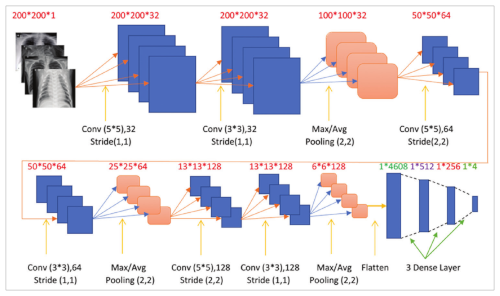



In [ ]:
 def get_modified_vggnet():
  convolutional_layers_number = 2
  channels = [32, 64, 128]
  
  model = keras.Sequential()
  model.add(layers.Input(shape=images_shape,name='Input'))

  # First Block
  model.add(layers.Conv2D(filters=32,
                          kernel_size=3, 
                          padding='same',
                          strides=1,
                          activation='relu'))      
  model.add(layers.Conv2D(filters=32,
                          kernel_size=3,
                          strides=1, 
                          padding='same',
                          activation='relu'))      
  model.add(layers.MaxPool2D(pool_size=2))

  # Second block
  model.add(layers.Conv2D(filters=64,
                          kernel_size=3, 
                          padding='same',
                          strides=2,
                          activation='relu'))      
  model.add(layers.Conv2D(filters=64,
                          kernel_size=3,
                          strides=1, 
                          padding='same',
                          activation='relu'))      
  model.add(layers.MaxPool2D(pool_size=2))

  # Third block
  model.add(layers.Conv2D(filters=128,
                          kernel_size=3, 
                          padding='same',
                          strides=2,
                          activation='relu'))      
  model.add(layers.Conv2D(filters=128,
                          kernel_size=3,
                          strides=1, 
                          padding='same',
                          activation='relu'))      
  model.add(layers.MaxPool2D(pool_size=2))

  # Fully Connected part
  model.add(layers.Flatten())
  model.add(layers.Dense(units=512, activation='relu',name='FC1'))
  model.add(layers.Dense(units=256, activation='relu',name='FC2'))
  model.add(layers.Dense(units=class_count, activation='softmax', name='Output'))
  
  return model

In queso caso il modello viene creato con una funzione ad-hoc che implementa l'architettura VGGNet modificata; analogamente a prima si stampa la struttura del modello con le funzioni summary() e plot_model().

In [ ]:
modified_vggnet16 = get_modified_vggnet()
modified_vggnet16.summary()
keras.utils.plot_model(modified_vggnet16,show_shapes=True)

In [ ]:
# mlflow.start_run()
# mlflow.set_tag('model_name', 'modified_vgg16')
# mlflow.set_tag('number_classes', str(class_count))
# Autologs all the parameters, the metrics used in the training
# mlflow.tensorflow.autolog()

In [ ]:
epochs_number=50
learning_rate = 0.000045

optimizer=keras.optimizers.Adam(learning_rate=learning_rate)
modified_vggnet16.compile(optimizer=optimizer, loss=keras.losses.categorical_crossentropy,
              metrics=metrics)

Anche in questo caso si è utilizzata patience bassa in quanto con valori più alti i risultati non variavano.

In [ ]:
patience = 3
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                                               patience=patience,
                                               verbose=1,
                                               restore_best_weights=True)
history = modified_vggnet16.fit(x = training_set_iterator,
                    validation_data = validation_set_iterator,
                    epochs = epochs_number,
                    callbacks=[early_stopping])
#mlflow.end_run()

In [ ]:
plot_history(history,metric='accuracy')
plot_history(history, metric='precision')
plot_history(history, metric='recall')
plot_history(history, metric='f1_score')

### ResNet

Le *Residual Network* (ResNet) sono realizzate sul framework *Residual Learning*[8], da cui prendono il nome. Grazie al framework è possibile affrontare il problema del degrado dell'accuratezza durante l'addestramento di reti profonde. Tale degrado non dipende dall'overfitting, ma dalla profondità della rete.

Il *Residual Learning* consiste nell'apprendere la funzione residua rispetto all'input  passato al primo livello del blocco, piuttosto che apprendere la funzione non referenziata, ottenuta da numerosi livelli non lineari disposti in stack.

Elementi costitutivi delle ResNet sono i *Residual Block*, le *skip connection*.

<img src="https://i.stack.imgur.com/cpJgP.png">

Il **Residual Block** è costituito dalla *Residual Function F(x)* e dalla *skip connection*, a cui segue la somma elemento per elemento delle feature map corrispondenti ottendo la mappatura *H(x) = F(x) + x*.

La **Residual Function** è ottenuta disponendo, in stack, due livelli di convoluzione, o più in generale di proiezione lineare, come mostrato nell'immagine di sinistra. Mentre , tra i due livelli, viene applicata l'attivazione non lineare, ovvero la ReLU.

Il **Residual Bottleneck** (immagine a destra) non è altro che una *Residual function* estesa per architettura più profonde (ResNet-50, ResNet-101 e ResNet152) al fine di ridurre i tempi dell'addestramento. Consiste in tre livelli di convoluzione, dove i livelli 1x1 sono responsabili della riduzione e poi dell'aumento (ripristino) delle dimensioni, mentre il livello 3x3 è definito di bottleneck in quanto riduce le dimensioni spaziali in input.

La **skip connection** può essere di due tipi:
*   **Identity**: quando *F(x)* preserva le dimensioni dell’input x.
*   **Convolutional**: quando *F(x)* non ha le stesse dimensioni di x, per cui é necessario ridimensionare l’input applicando un livello di convoluzione con strides=2.

Infine, il problema del **vanishing/exploding gradients** è stato risolto aggiungendo livelli di normalizzazione dopo ogni livello di convoluzione.

Nella tabella sottostante vengono mostrati i dettagli delle architetture ResNet, sia shallow che deep. In particolare, tutte le varianti hanno un primo livello di convoluzione in cui vengono estratte feature di basso livello, seguito da 4 stage. Ogni stage contiene un numero di *Residual Function* (per reti shallow) o *Residual Bottleneck* (per reti deep).

<img src="https://neurohive.io/wp-content/uploads/2019/01/resnet-architectures-34-101.png" alt="ReseNets Architectures Details" width="960"/>

#### Definizione del modello
 Di seguito è stata implementata l'architettura generale delle varie *Residual Network*, in modo da avere flessibilità nell'istanziare una rete shallow o una deep configurando semplicemente il numero di *Residual Block* per stage, il numero di livelli nel *Residual Block* con le dimensioni dei filtri convoluzionali ed il numero di classi.

La funzione *addition* incapsula semplicemente la logica dell'operatore somma applicato al risultato della funzione residua *F(x)* e all'input *x* del *Residual Block* ed applica l'attivazione non lineare al risultato ottenuto.

In [ ]:
def addition(f_x, x):
    h_x = layers.add([f_x, x])
    return activations.relu(h_x)

La funzione *skip_connection* prende in ingresso l'input *x* del *Residual Block*, ed eventualmente il numero di feature maps utile per la *convolutional skip connection* e lo stride. In quest'ultimo caso, dopo il livello di convoluzione viene applicata anche la normalizzazione.

In [ ]:
def skip_connection(input, feature_maps, stride=None):
    if stride==None:
        return input
    
    x = layers.Conv2D(kernel_size=1, filters=feature_maps, padding='valid', strides=stride)(input)
    return layers.BatchNormalization()(x)

In [ ]:
def get_stride(i, identity):
    return 2 if not identity and i==0 else 1

def get_padding(i):
    return 'same' if i==1 else 'valid'

def input_validation(filters, feature_maps):
    number_of_filter = len(filters)
    number_of_feature_maps = len(feature_maps)
    
    if not number_of_feature_maps == number_of_filter:
        raise AttributeError("Feature Maps and Filters must have the same value")

La *residual_function* applica i livelli di convoluzione in base alle dimensioni (*filters*) e al numero (*feature_maps*) dei filtri convoluzionali.

Viene applicata la normalizzazione e l'attivazione non lineare dopo tutti i livelli di convoluzione, ad eccezione dell'ultimo. Dopo questo livello viene applicata solo la normalizzazione, mentre l'attivazione la si applica nell'*addition*.

Nel caso di architetture profonde avremo la cosiddetta *Residual Bottleneck*.

In [ ]:
def residual_function(filters, feature_maps, stride, input): 
    f_x = input
    
    for i, filter in enumerate(filters):
        padding = get_padding(i)
        stride = stride if i==0 else 1
        f_x = layers.Conv2D(kernel_size=filter, filters=feature_maps[i], padding=padding, strides=stride)(f_x)
        f_x = layers.BatchNormalization()(f_x)
        
        if i < len(filters) - 1:
            f_x = activations.relu(f_x)
    return f_x

La *resnet_block* compone la *residual_function*, la *skip_connection* e l'*addition*, calcolando il valore stride. Se viene passato un valore stride di 1 o 2 allora lo si applica (questo è il caso del primo blocco di ogni stage, con la differenza che nel primo stage stride=1 perché le dimensioni dell'input *x* e di *F(x)* sono le medesime, mentre negli altri stage stride=2 per ridimensionare l'input *x*).
Diversamente, se lo stride=None allora si sta modellando un blocco avente *identity skip connection*.

In [ ]:
def resnet_block(filters, feature_maps, input, stride=None):
    input_validation(filters, feature_maps)
    
    strides = stride if stride else 1
    f_x = residual_function(filters,
                feature_maps,
                stride=strides, input=input)

    x = skip_connection(input, feature_maps[-1], stride)
    
    print("Before addition >> f_x:", f_x.shape, "\tx: ", x.shape)
    return addition(f_x, x)

La funzione *residual_stage*, banalmente, crea il numero di blocchi necessari per lo specifico stage, grazie al numero di blocchi per stage (*number_of_blocks*), alle dimensioni (*filters*) e al numero (*feature_maps*) di filtri convoluzionali.

In [ ]:
def residual_stage(filters, feature_maps, number_of_blocks, stride, input):
    stage = resnet_block(filters, feature_maps, input, stride)
    for i in range(number_of_blocks - 1):
        stage = resnet_block(filters, feature_maps, stage)
    return stage

Infine, la funzione *resnet_v1* crea il modello finale, definendo
* il livello di input
* il livello di padding per aumentare le dimensioni spaziali
* il livello di convoluzione con kernel_size=7x7, strides=2 e filtri=64
* la BatchNormalization seguita dalla ReLU
* il lvello di padding per aumentare nuovamente le dimensioni spaziali
* il livello di max pooling per avere le prime caratterisitche delle immagini
* i 4 stage
* il livello di GlobalAveragePooling per avere caratterisitche di alto livello
*il livello fully-connected con attivazione softmax in modo da avere la predizione delle probabilità per ciascuna classe.

In [ ]:
def resnet_v1(classes, filters, feature_maps, number_of_blocks, shape=(224, 224, 3)):
    input = layers.Input(shape=shape, name='Input')
    print("Input: ", input.shape)
    
    output = layers.ZeroPadding2D(padding=(3, 3))(input)
    output = layers.Conv2D(filters=64, kernel_size=(7, 7), strides=(2, 2))(output)
    print("Conv2D: ", output.shape)

    output = layers.BatchNormalization()(output)
    output = activations.relu(output)

    output = layers.ZeroPadding2D()(output)
    output = layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(output)
    print("MaxPooling2D: ", output.shape)

    for i in range(4):
        stride = 1 if i==0 else 2
        output = residual_stage(filters, feature_maps[i], number_of_blocks=number_of_blocks[i], stride=stride, input=output)
        print("Stage ", i+1, ": ", output.shape)

    output = layers.GlobalAveragePooling2D()(output)
    output = layers.Dense(classes, activation='softmax', name='Output')(output)
    print("Output: ", output.shape)
    
    return keras.Model(inputs=input, outputs=output)

#### ResNet50

<img src="https://blogs.nottingham.ac.uk/digitalresearch/files/2020/08/resnet.png" alt="ReseNets Architectures Details" width="1000"/>


Avendo il modello della ResNet originale, è possibile istanziare qualsiasi variante, sia shallow che deep, definendo la matrice delle feature maps (filtri in keras), la dimensione dei filtri (kernel_zise in keras) ed il numero di blocchi per ciascuno stage, oltre al numero di classi e alla shape dell'input.

In [ ]:
filters=[1, 3, 1] #kernel_size
feature_maps=[[64, 64, 256], [128, 128, 512], [256, 256, 1024], [512, 512, 2048]] #filters
number_of_blocks=[3, 4, 6, 3]

resnet50v1 = resnet_v1(classes=class_count, filters=filters, feature_maps=feature_maps, number_of_blocks=number_of_blocks, shape=target_size)

In [ ]:
resnet50v1.summary()

In [ ]:
keras.utils.plot_model(resnet50v1, show_shapes=True, show_dtype=True)

**Definizione degli iper-parametri**

In [ ]:
learning_rate = 0.0001
optimizer=optimizers.Adam(learning_rate=learning_rate, amsgrad=True)
epoch_count=100
patience=10

In [ ]:
# Autologs all the parameters, the metrics used in the training
# mlflow.start_run()
# mlflow.set_tag('model_name', 'resnet50v1_')
# mlflow.set_tag('num_classes', str(class_count))
# mlflow.tensorflow.autolog()

**Compile del modello**

In [ ]:
resnet50v1.compile(optimizer=optimizer, loss=keras.losses.categorical_crossentropy, metrics=metrics)

**Addestramento**

In [ ]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
history = resnet50v1.fit(x=training_set_iterator, validation_data=validation_set_iterator, epochs=epoch_count, callbacks=[early_stop])
# mlflow.end_run()

In [ ]:
plot_history(history,metric='accuracy')
plot_history(history, metric='precision')
plot_history(history, metric='recall')
plot_history(history, metric='f1_score')

#### ResNet101

La ResNet101 é molto simile alla ResNet50. L’unica differenza é data dal numero di livelli presenti nello stage 3.
Mentre la ResNet50 ha 6 livelli di convoluzione, la ResNet101 ne ha 23.

In [ ]:
filters=[1, 3, 1]
feature_maps=[[64, 64, 256], [128, 128, 512], [256, 256, 1024], [512, 512, 2048]]
number_of_blocks=[3, 4, 23, 3]

resnet101v1 = resnet_v1(classes=class_count, filters=filters, feature_maps=feature_maps, number_of_blocks=number_of_blocks, shape=target_size)

In [ ]:
resnet101v1.summary()

In [ ]:
keras.utils.plot_model(resnet101v1, show_shapes=True, show_dtype=True)

**Definizione degli iper-parametri**

In [ ]:
learning_rate=0.0001
optimizer=optimizers.RMSprop(rho=0.9, learning_rate=learning_rate)
epoch_count=100
patience=10

In [ ]:
# mlflow.start_run()
# Autologs all the parameters, the metrics used in the training
# mlflow.set_tag('model_name', 'resnet101v1_')
# mlflow.set_tag('num_classes', str(class_count))
# mlflow.tensorflow.autolog()

**Compile del modello**

In [ ]:
resnet101v1.compile(optimizer=optimizer, loss=keras.losses.categorical_crossentropy, metrics=metrics)

**Addestramento**

In [ ]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
history = resnet101v1.fit(x=training_set_iterator, validation_data=validation_set_iterator, epochs=epoch_count, callbacks=[early_stop])
# mlflow.end_run()

In [ ]:
plot_history(history,metric='accuracy')
plot_history(history, metric='precision')
plot_history(history, metric='recall')
plot_history(history, metric='f1_score')

#### ResNet v2 modificata

La *ResNet v2* [9] si focalizza sulla *idenity skip_connection* e sulla funzione di attivazione, fornendo un nuovo design per la *Residual Function*. 

A differenza della ResNet orginale, il paper[2] proprone una variante che adotta la *full pre-activation*, come mostrato nell'immagine di destra. La normalizzazione e l'attivazione non lineare vengono applicate prima di ciascun livello di convoluzione. Questo porta all'eliminazione dell'attivazione dopo l'*addition*, ottenendo così l'apprendimento dell'*identity mapping*.

<img src="https://drive.google.com/uc?export=view&id=1fRwu_NNqdjG6vkd-oeLxVMl2A-pNBkPM" alt="ReseNets Architectures Details" width="640"/>

Inoltre, al fine di ottenere una *identity skip connection*, riducendo così i parametri addestrabili (molto utile per reti estramemente profonde, come la ResNet-152, ResNet-164, ResNet-1001, ecc) permette di semplificare l'apprendimento dell'*identity mapping*.
Al fine di eliminare la convoluzione 1x1 sulla *skip connection*, si utilizza un livello di *max poooling* per ridurre le dimensioni spaziali ed un livello di *zero-padding* per incrementare il numero di filtri/canali dell'input *x* affinché abbia le stesse dimensioni di *F(x)* senza avere extra parametri.



In [ ]:
def addition(f_x, x):
    return layers.add([f_x, x])

def skip_connection(input, desired_feature_maps, stride=None):
    input_feature_maps=input.shape[-1]
    if input_feature_maps==desired_feature_maps:
        return input
    
    x = input
    if stride:
      x = layers.MaxPooling2D(pool_size=(2,2))(x)
    
    padding=int((desired_feature_maps-input_feature_maps)/2)
    return layers.ZeroPadding2D(padding=(0, padding), data_format='channels_first')(x)

def get_stride(i, identity):
    return 2 if not identity and i==0 else 1

def get_padding(i):
    return 'same' if i==1 else 'valid'

def residual_function(filters, feature_maps, stride, input):  
    f_x = input
    
    for i, filter in enumerate(filters):
        padding = get_padding(i)
        stride = stride if i==0 else 1
        f_x = layers.BatchNormalization()(f_x)
        f_x = activations.relu(f_x)
        f_x = layers.Conv2D(kernel_size=filter, filters=feature_maps[i], padding=padding, strides=stride)(f_x)            
    return f_x

def input_validation(filters, feature_maps):
    number_of_filter = len(filters)
    number_of_feature_maps = len(feature_maps)
    
    if not number_of_feature_maps == number_of_filter:
        exception

def resnet_block(filters, feature_maps, input, stride=None):
    input_validation(filters, feature_maps)
    
    strides = stride if stride else 1
    f_x = residual_function(filters,
                feature_maps,
                stride=strides, input=input)

    x = skip_connection(input, f_x.shape[-1], stride=stride if stride==2 else None)
    
    print("Before addition >> f_x:", f_x.shape, "\tx: ", x.shape)
    return addition(f_x, x)

def residual_stage(filters, feature_maps, number_of_blocks, stride, input):
    stage = resnet_block(filters, feature_maps, input, stride)
    for i in range(number_of_blocks - 1):
        stage = resnet_block(filters, feature_maps, stage)
    return stage

def resnet_v2(classes, filters, feature_maps, number_of_blocks, shape=(224, 224, 3)):
    input = layers.Input(shape=shape)
    print("Input: ", input.shape)
    
    output = layers.ZeroPadding2D(padding=(3, 3))(input)

    output = layers.BatchNormalization()(output)
    output = activations.relu(output)
    output = layers.Conv2D(filters=64, kernel_size=(7, 7), strides=(2, 2))(output)
    print("Conv2D: ", output.shape)

    output = layers.ZeroPadding2D()(output)
    output = layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(output)
    print("MaxPooling2D: ", output.shape)

    for i in range(4):
        stride = 1 if i==0 else 2
        output = residual_stage(filters, feature_maps[i], number_of_blocks=number_of_blocks[i], stride=stride, input=output)
        print("Stage ", i+1, ": ", output.shape)

    output = layers.GlobalAveragePooling2D()(output)
    output = layers.Dense(classes, activation='softmax')(output)
    print("Output: ", output.shape)
    
    return keras.Model(inputs=input, outputs=output)


##### ResNet50

In [ ]:
filters=[1, 3, 1]
feature_maps=[[64, 64, 256], [128, 128, 512], [256, 256, 1024], [512, 512, 2048]]
number_of_blocks=[3, 4, 6, 3]

resnet50v2 = resnet_v2(classes=class_count, filters=filters, feature_maps=feature_maps, number_of_blocks=number_of_blocks, shape=target_size)

In [ ]:
resnet50v2.summary()

In [ ]:
keras.utils.plot_model(resnet50v2, show_shapes=True, show_dtype=True)

**Definizione degli iper-parametri**

In [ ]:
learning_rate=0.0001
optimizer=optimizers.Adamax(learning_rate)
epoch_count=100
patience=10

In [ ]:
# mlflow.start_run()
# Autologs all the parameters, the metrics used in the training
# mlflow.set_tag('model_name', 'resnet50v2_')
# mlflow.set_tag('num_classes', str(class_count))
# mlflow.tensorflow.autolog()

**Compile del modello**

In [ ]:
resnet50v2.compile(optimizer=optimizer, loss=keras.losses.categorical_crossentropy, metrics=metrics)

**Addestramento**

In [ ]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
history = resnet50v2.fit(x=training_set_iterator, validation_data=validation_set_iterator, epochs=epoch_count, callbacks=[early_stop])
# mlflow.end_run()

In [ ]:
plot_history(history,metric='accuracy')
plot_history(history, metric='precision')
plot_history(history, metric='recall')
plot_history(history, metric='f1_score')

##### ResNet101

In [ ]:
filters=[1, 3, 1]
feature_maps=[[64, 64, 256], [128, 128, 512], [256, 256, 1024], [512, 512, 2048]]
number_of_blocks=[3, 4, 23, 3]

resnet101v2 = resnet_v2(classes=class_count, filters=filters, feature_maps=feature_maps, number_of_blocks=number_of_blocks, shape=target_size)

In [ ]:
resnet101v2.summary()

In [ ]:
keras.utils.plot_model(resnet101v2, show_shapes=True, show_dtype=True)

**Definizione degli iper-parametri**

In [ ]:
learning_rate = 0.0001
optimizer=optimizers.Adam(learning_rate=learning_rate, amsgrad=True)
epoch_count=100
patience=10

In [ ]:
# mlflow.start_run()
# Autologs all the parameters, the metrics used in the training
# mlflow.set_tag('model_name', 'resnet101v2_')
# mlflow.set_tag('num_classes', str(class_count))
# mlflow.tensorflow.autolog()

In [ ]:
resnet101v2.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=metrics)

**Addestramento**

In [ ]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
history = resnet101v2.fit(x=training_set_iterator, validation_data=validation_set_iterator, epochs=epoch_count, callbacks=[early_stop])
# mlflow.end_run()

In [ ]:
plot_history(history,metric='accuracy')
plot_history(history, metric='precision')
plot_history(history, metric='recall')
plot_history(history, metric='f1_score')

### Inception



#### Inception-v1 (GoogleNet)




![alt text](https://cdn.analyticsvidhya.com/wp-content/uploads/2018/10/googlenet.png)

GoogLeNet è composta da:


*   3 convolutional layer
*   4 max pooling layer 
*   1 global average pooling layer
*   9 moduli inception
*   1 fully-connected layer

Per l'architettura nel dettaglio si fa riferimento a [6].












Nell'architettura originale sono presenti dei classificatori ausiliari composti come segue da:


*   1 average pooling con filtro 5x5
*   1 convoluzione 1x1
*   1 strato completamente connesso
* 1 dropuot layer (ratio 70%)
* 1 linear layer con softmax loss come classificatore

Nella creazione del modello **NON** sono stati utilizzati perchè nei vari addestramenti non si sono notati particolari benifici in termini di tempo e prestazioni.




In [ ]:
def create_auxiliary_classifier(input, aux_name=None):
  x = layers.AveragePooling2D(pool_size=(5,5),strides=3)(input)
  x = layers.Conv2D(filters=128,kernel_size=1, padding="same", activation="relu")(x)
  x = layers.Flatten()(x)
  x = layers.Dense(units=1024, activation="relu")(x)
  x = layers.Dropout(rate=0.7)(x)
  x =layers.Dense(units=4, activation="softmax", name=aux_name)(x)
  return x

Nell'architettua sono presenti 9 moduli incepton composti da quattro percorsi, come viene mostrato nell'immagine seguente, i cui output vengono concatenati.

![alt text](https://cdn.analyticsvidhya.com/wp-content/uploads/2018/10/Screenshot-from-2018-10-17-11-14-10.png)

La cella seguente serve a creare i singoli moduli inception.



In [ ]:
def create_inception_module(input, filter_p1, filter_p2, filter_p3, filter_p4, inception_module_name=None):

  path_1 = layers.Conv2D(filters=filter_p1, kernel_size=1, strides=1,activation='relu',padding='same')(input)

  path_2 = layers.Conv2D(filters=filter_p2[0], kernel_size=1, strides=1,activation='relu',padding='same')(input)
  path_2 = layers.Conv2D(filters=filter_p2[1], kernel_size=3, strides=1,activation='relu',padding='same')(path_2)

  path_3 = layers.Conv2D(filters=filter_p3[0], kernel_size=1, strides=1,activation='relu',padding='same')(input)
  path_3 = layers.Conv2D(filters=filter_p3[1], kernel_size=5, strides=1,activation='relu',padding='same')(path_3)

  path_4 = layers.MaxPooling2D(pool_size=(3,3), strides=1, padding='same')(input)
  path_4 = layers.Conv2D(filters=filter_p4, kernel_size=1, strides=1, padding='same', activation='relu')(path_4)
     
  return layers.Concatenate(axis=-1,name= inception_module_name)([path_1,path_2,path_3,path_4])


La seguente funzione serve a creare un modello di googLeNet.


*   input_shape atteso è (224,224,1)
*   output_class_count è uguale a 4 perchè vogliamo fare una classificazione multi-classe [COVID, Lung_Opacity, Normal, Viral Pneumonia].

Per creare il modello è stata utilizzata [**keras functional API**](https://keras.io/guides/functional_api/).

In [ ]:
def create_googLeNet(input_shape=(224, 224, 1),output_class_count=4):
    input= layers.Input(shape=input_shape,name='Input')
    x = layers.Conv2D(filters=64, kernel_size=7, strides=2,activation='relu',padding='same',name='Conv1')(input)
    x = layers.MaxPool2D(pool_size=(3,3),padding="same",strides=2,name="MaxPool_1")(x)
    x = layers.Conv2D(filters=64, kernel_size=1, strides=1,activation='relu',padding='same',name='Conv2')(x)
    x = layers.Conv2D(filters=192, kernel_size=3, strides=1,activation='relu',padding='same',name='Conv3')(x)
    x = layers.MaxPool2D(pool_size=(3,3),padding="same",strides=2,name="MaxPool_2")(x)

    #inception_module
    x =create_inception_module(x,filter_p1=64, filter_p2=(96,128),filter_p3=(16,32),filter_p4=32, inception_module_name= "inception_module1")
    x =create_inception_module(x,filter_p1=128, filter_p2=(128,192),filter_p3=(32,96),filter_p4=64, inception_module_name= "inception_module2")

    x = layers.MaxPool2D(pool_size=(3,3), strides=2, padding="same",name="MaxPool_3")(x)

    #inception_module
    x =create_inception_module(x,filter_p1=192, filter_p2=(96,208),filter_p3=(16,48),filter_p4=64, inception_module_name= "inception_module3")
    
    #auxiliary_classifier
    #x1=create_auxiliary_classifier(x, aux_name="auxiliary_classifier_1")

    x =create_inception_module(x,filter_p1=160, filter_p2=(112,124),filter_p3=(24,64),filter_p4=64, inception_module_name= "inception_module4")
    x =create_inception_module(x,filter_p1=128, filter_p2=(128,256),filter_p3=(24,64),filter_p4=64, inception_module_name= "inception_module5")
    x =create_inception_module(x,filter_p1=112, filter_p2=(144,288),filter_p3=(32,64),filter_p4=64, inception_module_name= "inception_module6") 
    x =create_inception_module(x,filter_p1=256, filter_p2=(160,320),filter_p3=(32,128),filter_p4=128, inception_module_name= "inception_module7")

    #auxiliary_classifier
    # x2 = create_auxiliary_classifier(x, aux_name="auxiliary_classifier_2")

    x = layers.MaxPool2D(pool_size=(3,3),strides=2, padding="same",name="MaxPool_4")(x)

    #inception_module
    x =create_inception_module(x,filter_p1=256, filter_p2=(160,320),filter_p3=(32,128),filter_p4=128, inception_module_name= "inception_module8")
    x =create_inception_module(x,filter_p1=384, filter_p2=(192,384),filter_p3=(48,128),filter_p4=128, inception_module_name= "inception_module9")
    x = layers.GlobalAveragePooling2D(name="global_average_pool")(x)
    x = layers.Dropout(rate=0.4)(x)

    output=layers.Dense(units=output_class_count,activation='softmax',name='Output')(x)
    model = keras.Model(inputs=input, outputs=output, name="googlenet")    
    return model

Creazione del modello

In [ ]:
googlenet=create_googLeNet()

In [ ]:
googlenet.summary()
keras.utils.plot_model(googlenet, show_shapes=True, show_dtype=True)

La cella seguente è utile durante la fase di addestramento per salvare l'esperimento su DAGsHub. Vengono aggiunti i tag relativi al nome del modello e al numero di classi. Con il metodo autolog(), si imposta il log automatico di iperparametri e metriche nell'experiment tracker.

In [ ]:
#mlflow.start_run()
# Set the name of the model and the number of classes in the experiment tracker
#mlflow.set_tag('model_name', 'googLenet')
#mlflow.set_tag('num_classes', str(class_count))
# Autologs all the parameters, the metrics used in the training
#mlflow.tensorflow.autolog()

Nella cella seguente viene addestrato il modello. Dopo vari addestramenti i risultati migliori si sono ottenuti con l'ottimizzatore Nadam e con un learning rate di 0.0001. 

La patience è stata impostata a 5 perchè con un valore più alto la rete oscillava, impiegando molto tempo per l'addestramento ma senza raggiungere risultati migliori.

In [ ]:
epochs_number=100
learning_rate = 0.0001

optimizer=keras.optimizers.Nadam(learning_rate=learning_rate)
googlenet.compile(optimizer=optimizer, loss=keras.losses.categorical_crossentropy,
              metrics=metrics)

patience = 5
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, verbose=1, restore_best_weights=True)
history = googlenet.fit(x = training_set_iterator, validation_data = validation_set_iterator, epochs = epochs_number, callbacks=[early_stopping])
# mlflow.end_run()

In [ ]:
plot_history(history,metric='accuracy')
plot_history(history, metric='precision')
plot_history(history, metric='recall')
plot_history(history, metric='f1_score')

#### Inception-v4

![alt text](https://www.programmersought.com/images/322/aec6da030649bb68b862b3ee15bc1f5a.png)

Nella figura viene mostrata Inception-v4 nel complesso.
Notiamo che sono presenti 3 blocchi di inception (A,B,C), con dimensioni di filtri differenti. In totale sono presenti 14 moduli inception.

Stem rappresenta la parte iniziale della rete, troviamo questo termine per la prima volta in Inception-v4, nelle versioni precedenti non è presente.[7]

Inception-v4 richiede immagini (299,299), il dataset viene quindi splittato di nuovo nella cella seguente.



In [ ]:
 training_set_iterator, validation_set_iterator, test_set_iterator = split_dataset(target_size=(299,299), color_mode="grayscale")

Dopo ogni convoluzione viene fatta batch normalizzation + Relu. Per rendere il codice più snello viene incapsulata questa logica nella funzione seguente.

In [ ]:
def ConvBlock(filters, kernel_size, strides, padding, input):
  x= layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding=padding)(input)
  x= layers.BatchNormalization()(x)
  x= layers.Activation('relu')(x)
  return x

In [ ]:
def stem (input, name=None):
  x = ConvBlock(filters=32, kernel_size=3, strides=2, padding='valid', input=input)
  x = ConvBlock(filters=32, kernel_size=3, strides=1, padding='valid', input=x)
  x = ConvBlock(filters=64, kernel_size=3, strides=1, padding='same', input=x)
  x1 = layers.MaxPool2D(pool_size=(3,3), strides=2, padding='valid')(x)
  x2 = ConvBlock(filters=96, kernel_size=3, strides=2, padding='valid', input=x)
  x = layers.Concatenate(axis=-1)([x1, x2])
  x3 = ConvBlock(filters=64, kernel_size=1, strides=1, padding='same', input=x)
  x3 = ConvBlock(filters=96, kernel_size=3, strides=1, padding='valid', input=x3)
  x4 = ConvBlock(filters=64, kernel_size=1, strides=1, padding='same', input=x)
  x4 = ConvBlock(filters=64, kernel_size=(7,1), strides=1, padding='same', input=x4)
  x4 = ConvBlock(filters=64, kernel_size=(1,7), strides=1, padding='same', input=x4)
  x4 = ConvBlock(filters=96, kernel_size=3, strides=1, padding='valid', input=x4)
  x = layers.Concatenate(axis=-1)([x3, x4])
  x5 = ConvBlock(filters=192, kernel_size=3, strides=2, padding='valid', input=x)
  x6 = layers.MaxPool2D(pool_size=(2,2), strides=2, padding='valid')(x)
  x = layers.Concatenate(axis=-1, name=name)([x5, x6])
  
  return x

In [ ]:
def inception_A_block(input, name=None):
  
  path_1 = layers.AvgPool2D(pool_size=(2,2), strides=1, padding='same')(input)
  path_1 = ConvBlock(filters=96, kernel_size=1, strides=1, padding='valid', input=path_1)

  path_2 = ConvBlock(filters=96, kernel_size=1, strides=1, padding='same', input=input)

  path_3 = ConvBlock(filters=64, kernel_size=1, strides=1, padding='same', input=input)
  path_3 = ConvBlock(filters=96, kernel_size=3, strides=1, padding='same', input=path_3)

  path_4 = ConvBlock(filters=64, kernel_size=1, strides=1, padding='same', input=input)
  path_4 = ConvBlock(filters=96, kernel_size=3, strides=1, padding='same', input=path_4)
  path_4 = ConvBlock(filters=96, kernel_size=3, strides=1, padding='same', input=path_4)

  
  return layers.Concatenate(axis=-1,name= name)([path_1,path_2,path_3,path_4])


In [ ]:
def inception_B_block(input, name=None):
  path_1 = layers.MaxPool2D(pool_size=(2,2), strides=1, padding='same')(input)
  path_1 = ConvBlock(filters=128, kernel_size=1, strides=1, padding='same', input=path_1) 

  path_2 = ConvBlock(filters=384, kernel_size=1, strides=1, padding='same', input=input)


  path_3 = ConvBlock(filters=192, kernel_size=1, strides=1, padding='same', input=input)
  path_3 = ConvBlock(filters=224, kernel_size=(1,7), strides=1, padding='same', input=path_3)
  path_3 = ConvBlock(filters=256, kernel_size=(7,1), strides=1, padding='same', input=path_3)

  path_4 = ConvBlock(filters=192, kernel_size=1, strides=1, padding='same', input=input)
  path_4 = ConvBlock(filters=192, kernel_size=(1,7), strides=1, padding='same', input=path_4)
  path_4 = ConvBlock(filters=224, kernel_size=(7,1), strides=1, padding='same', input=path_4)
  path_4 = ConvBlock(filters=224, kernel_size=(1,7), strides=1, padding='same', input=path_4)
  path_4 = ConvBlock(filters=256, kernel_size=(7,1), strides=1, padding='same', input=path_4)
 
  return layers.Concatenate(axis=-1,name= name)([path_1,path_2,path_3,path_4])


In [ ]:
def inception_C_block(input, name=None):
  path_1 = layers.MaxPool2D(pool_size=(2,2), strides=1, padding='same')(input)
  path_1 = ConvBlock(filters=256, kernel_size=1, strides=1, padding='same', input=path_1)
  
  path_2 = ConvBlock(filters=256, kernel_size=1, strides=1, padding='valid', input=input)

  path_3 = ConvBlock(filters=384, kernel_size=1, strides=1, padding='same', input=input)
  path_3a = ConvBlock(filters=256, kernel_size=(1,3), strides=1, padding='same', input=path_3)
  path_3b = ConvBlock(filters=256, kernel_size=(3,1), strides=1, padding='same', input=path_3)
  
  path_4 = ConvBlock(filters=384, kernel_size=1, strides=1, padding='valid', input=input)
  path_4 = ConvBlock(filters=448, kernel_size=(1,3), strides=1, padding='same',input=path_3)
  path_4 = ConvBlock(filters=512, kernel_size=(3,1), strides=1, padding='same',input=path_3)
  path_4a = ConvBlock(filters=256, kernel_size=(3,1), strides=1,padding='same', input=path_3)
  path_4b = ConvBlock(filters=256, kernel_size=(1,3), strides=1, padding='same', input=path_3)
  
     
  return layers.Concatenate(axis=-1,name= name)([path_1,path_2, path_2, path_3a, path_3b, path_4a, path_4b])


In [ ]:
def reduction_A(input, name=None):  
  K=192
  L=224
  M=256
  N=384

  path_1 = layers.MaxPool2D(pool_size=(3,3), strides=2, padding='valid')(input)
    
  path_2 = ConvBlock(filters=N, kernel_size=3, strides=2, padding='valid', input=input)

  path_3 = ConvBlock(filters=K, kernel_size=1, strides=1, padding='same', input=input)
  path_3 = ConvBlock(filters=L , kernel_size=3, strides=1, padding='same', input=path_3)
  path_3 = ConvBlock(filters=M, kernel_size=3, strides=2, padding='valid', input=path_3)
  
  return layers.Concatenate(axis=-1, name=name)([path_1,path_2,path_3])


In [ ]:
def reduction_B(input, name=None):  
  path_1 = layers.MaxPool2D(pool_size=(3,3), strides=2, padding='valid')(input)
    
  path_2 = ConvBlock(filters=192, kernel_size=1, strides=1, padding='same', input=input)
  path_2 = ConvBlock(filters=192, kernel_size=3, strides=2, padding='valid', input=path_2)

  path_3 = ConvBlock(filters=256, kernel_size=1, strides=1, padding='same', input=input)
  path_3 = ConvBlock(filters=256 , kernel_size=(1,7), strides=1, padding='same', input=path_3)
  path_3 = ConvBlock(filters=320, kernel_size=(7,1), strides=1, padding='same', input=path_3)
  path_3 = ConvBlock(filters=320, kernel_size=3, strides=2, padding='valid', input=path_3)
  
  return layers.Concatenate(axis=-1,name= name)([path_1,path_2,path_3])


In [ ]:
def create_inceptionv4(input_shape=(299, 299, 1),output_class_count=4):
    input= layers.Input(shape=input_shape, name='Input')
    x=stem(input, name='stem')

    #inception_moduleA x4
    for i in range(4):
      x=inception_A_block(x, name='inception_A'+ str(i+1))
    
    x = reduction_A(x, name='reduction_A')

    #inception_moduleB x7
    for i in range(7):
      x=inception_B_block(x, name='inception_B'+ str(i+1))
    
    x= reduction_B(x, name='reduction_B')
    
    #inception_moduleC x3
    for i in range(3):
      x=inception_C_block(x, 'inception_C'+ str(i+1))

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(rate=0.8, name="dropout")(x)
    output=layers.Dense(units=output_class_count, activation='softmax',name='Output')(x)
    model = keras.Model(inputs=input, outputs=[output], name="inception-v4")    
    return model

Creazione del modello

In [ ]:
inception_v4=create_inceptionv4()

In [ ]:
inception_v4.summary()
keras.utils.plot_model(inception_v4, show_shapes=True, show_dtype=True)

In [ ]:
#mlflow.start_run()
# Set the name of the model and the number of classes in the experiment tracker
# mlflow.set_tag('model_name', 'googLenet')
# mlflow.set_tag('num_classes', str(class_count))
# Autologs all the parameters, the metrics used in the training
#mlflow.tensorflow.autolog()

Nella cella seguente viene addestrato il modello. Dopo vari addestramenti i risultati migliori si sono ottenuti con l'ottimizzatore Nadam e con un learning rate di 0.0001. 

In [ ]:
epochs_number=100
learning_rate = 0.0001

optimizer=keras.optimizers.Nadam(learning_rate=learning_rate)
inception_v4.compile(optimizer=optimizer, loss=keras.losses.categorical_crossentropy,
              metrics=metrics)

patience = 5
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, verbose=1, restore_best_weights=True)
history = inception_v4.fit(x = training_set_iterator, validation_data = validation_set_iterator, epochs = epochs_number, callbacks=[early_stopping])
# mlflow.end_run()

In [ ]:
plot_history(history,metric='accuracy')
plot_history(history, metric='precision')
plot_history(history, metric='recall')
plot_history(history, metric='f1_score')

### Analisi delle prestazioni

Si risuddivide il dataset in quanto questo era stato splittato in modo da avere immagini (299, 299) per InceptionV4. Per i test delle altre reti sono di nuovo necessarie, invece, immagini (224, 224)

In [ ]:
training_set_iterator, validation_set_iterator, test_set_iterator = split_dataset()

Eseguendo l'analisi delle prestazioni dopo gli addestramenti, si è notato un errore "*ResourceExhaustedError:  OOM when allocating tensor*".

Per ovviare al problema la cella seguente, con "del", svincola le variabili di ciascun modello dall'area di memoria corrispondente; gc.collect() invoca il garbage collector per liberare la memoria non più utilizzata.

In [ ]:
from keras import backend as bek
import gc

del vgg16
del vgg19
del modified_vggnet16
del resnet50v1
del resnet50v2
del resnet101v1
del resnet101v2
del googlenet
del inception_v4
bek.clear_session()
gc.collect()

#### VGGNet

##### VGGNet-16

La cella seguente scarica il modello addestrato in precedenza. La cella successiva invece carica il modello scaricato.

In [ ]:
trained_model_path = "/content/vgg16.h5" 
path_to_downloaded_file = tf.keras.utils.get_file(
    trained_model_path,
    "https://cerimoniale.net/sito/uploads/2021/05/dl-project/models/vgg16_voice_baboon.h5")

In [ ]:
vgg16 = load_model(trained_model_path)
os.remove(trained_model_path)

VGGNet16, durante l'addestramento, ha ottenuto (sul training set) un'accuracy del 91.3%, auc 98.9%, f1-score del 91.3%, precision del 91.8% e recall del 90.8%. Sul validation set, durante l'addestramento l'accuracy è stata dell'88.0%, auc del 97.8%, f1-score del 87.9%, precision dell'88.6% e recall del 87%.

La cella seguente valuta le prestazioni sul test set. In questo caso i risultati ottenuti sono in linea con i risultati delle prediction sul validation set (cella successiva); si assume quindi che il modello stia generalizzando bene.

In [ ]:
loss, auc, f1_score, precision, recall, accuracy = vgg16.evaluate(test_set_iterator, batch_size=training_set_iterator.batch_size, verbose=0)

print('Test Set - Loss: {:.3f} AUC: {:.3f} F1-Score: {:.3f} Precision: {:.3f} \
       Recall: {:.3f} Accuracy: {:.3f}'.format(loss, auc, f1_score, 
                                               precision, recall, accuracy))

In [ ]:
loss, auc, f1_score, precision, recall, accuracy = vgg16.evaluate(validation_set_iterator,
                                                                  batch_size=training_set_iterator.batch_size,
                                                                  verbose=0)

print('Validation Set - Loss: {:.3f} AUC: {:.3f} F1-Score: {:.3f} Precision: {:.3f} \
       Recall: {:.3f} Accuracy: {:.3f}'.format(loss, auc, f1_score, 
                                               precision, recall, accuracy))

La cella seguente stampa la confusion matrix, relativa alla VGGNet16, sia in maniera testuale sia con un grafico colorato.

La matrice mostra valori più elevati nella cella ["Lung Opacity", "Normal"] e valori più bassi per ["Lung Opacity", "Lung Opacity"], evidenziando quindi come la rete compia errori in particolare nel classificare immagini di classe "Lung Opacity", indicandole soprattutto come immagini di classe "Normal".

In [ ]:
predictions = get_predictions(vgg16, test_set_iterator)
print_confusion_matrix(test_set_iterator.classes, predictions, colored=False)
print_confusion_matrix(test_set_iterator.classes, predictions, colored=True)
print(classification_report(test_set_iterator.classes, predictions, target_names=class_names))

##### VGGNet-19

In [ ]:
trained_model_path = "/content/vgg19.h5" 
path_to_downloaded_file = tf.keras.utils.get_file(
    trained_model_path,
    "https://cerimoniale.net/sito/uploads/2021/05/dl-project/models/vgg19_night_tiglon.h5")

In [ ]:
vgg19 = load_model(trained_model_path)
os.remove(trained_model_path)

VGGNet19 ha ottenuto, durante l'addestramento, risultati simili rispetto a VGGNet16. Sul training set un'accuracy del 90.9%, auc 98.8%, f1-score del 90.9%, precision del 91.5% e recall del 90.4%; sul validation set invece l'accuracy è stata dell'87.5%, auc 97%, f1-score del 87.5%, precision dell'88.4% e recall del 86.9%.

La cella seguente valuta le prestazioni sul test set. Anche nel caso di VGGNet19 i risultati ottenuti sul test set sono in linea con i risultati delle prediction sul validation set (cella successiva).

In [ ]:
loss, auc, f1_score, precision, recall, accuracy = vgg19.evaluate(test_set_iterator,
                                                                  batch_size=training_set_iterator.batch_size,
                                                                  verbose=0)

print('Test Set - Loss: {:.3f} AUC: {:.3f} F1-Score: {:.3f} Precision: {:.3f} \
       Recall: {:.3f} Accuracy: {:.3f}'.format(loss, auc, f1_score, 
                                               precision, recall, accuracy))

In [ ]:
loss, auc, f1_score, precision, recall, accuracy = vgg19.evaluate(validation_set_iterator,
                                                                  batch_size=training_set_iterator.batch_size,
                                                                  verbose=0)

print('Validation Set - Loss: {:.3f} AUC: {:.3f} F1-Score: {:.3f} Precision: {:.3f} \
       Recall: {:.3f} Accuracy: {:.3f}'.format(loss, auc, f1_score, 
                                               precision, recall, accuracy))

La cella seguente stampa la confusion matrix, relativa alla VGGNet19.

Anche con VGGNet19 la confusion matrix evidenzia una maggioranza di errori per immagini con label "Lung Opacity".

In [ ]:
predictions = get_predictions(vgg19, test_set_iterator)
print_confusion_matrix(test_set_iterator.classes, predictions, colored=False)
print_confusion_matrix(test_set_iterator.classes, predictions, colored=True)
print(classification_report(test_set_iterator.classes, predictions, target_names=class_names))

##### VGGNet modificata

In [ ]:
trained_model_path = "/content/modified_vgg16.h5" 
path_to_downloaded_file = tf.keras.utils.get_file(
    trained_model_path,
    "https://cerimoniale.net/sito/uploads/2021/05/dl-project/models/modified_vgg_dust_bovid.h5")

In [ ]:
modified_vggnet16 = load_model(trained_model_path)
os.remove(trained_model_path)

Durante l'addestramneto VGGNet16 modificata ha ottenuto risultati leggermente migliori rispetto alle due architetture orginali (VGGNet16 e VGGNet19). Sul training set VGGNet16 modificata ha raggiunto un'accuracy del 91.6%, auc 99%, f1-score del 91.5%, precision del 92.1% e recall del 91.1%; sul validation set invece l'accuracy è stata dell'88.9%, auc 98.2%, f1-score del 88.9%, precision dell'89.7% e recall del 88.1%.

La cella seguente valuta le prestazioni sul test set. I risultati ottenuti, da VGGNet16 modificata, sul test set sono simili ai risultati delle prediction sul validation set (cella successiva); si assume quindi che il modello stia generalizzando bene.

In [ ]:
loss, auc, f1_score, precision, recall, accuracy = modified_vggnet16.evaluate(test_set_iterator,
                                                                  batch_size=training_set_iterator.batch_size,
                                                                  verbose=0)

print('Test Set - Loss: {:.3f} AUC: {:.3f} F1-Score: {:.3f} Precision: {:.3f} \
       Recall: {:.3f} Accuracy: {:.3f}'.format(loss, auc, f1_score, 
                                               precision, recall, accuracy))

In [ ]:
loss, auc, f1_score, precision, recall, accuracy = modified_vggnet16.evaluate(validation_set_iterator,
                                                                  batch_size=training_set_iterator.batch_size,
                                                                  verbose=0)

print('Validation Set - Loss: {:.3f} AUC: {:.3f} F1-Score: {:.3f} Precision: {:.3f} \
       Recall: {:.3f} Accuracy: {:.3f}'.format(loss, auc, f1_score, 
                                               precision, recall, accuracy))

La cella seguente stampa la confusion matrix, relativa alla VGGNet16 modificata, sia in maniera testuale sia con un grafico colorato.

Anche in questo caso risulta evidente come la rete compia errori in particolare nel classificare immagini di classe "Lung Opacity", indicandole soprattutto come immagini di classe "Normal".

In [ ]:
predictions = get_predictions(modified_vggnet16, test_set_iterator)
print_confusion_matrix(test_set_iterator.classes, predictions, colored=False)
print_confusion_matrix(test_set_iterator.classes, predictions, colored=True)
print(classification_report(test_set_iterator.classes, predictions, target_names=class_names))

#### ResNet


##### ResNet50v1

Download e caricamento in memoria del modello addestrato con gli iperparametri migliori, ovvero:
*   Ottimizzatore: Adam
*   Learning rate: 0.0001
*   AMSGrad: True
*   Batch size: 32
*   Epochs: 100
*   Patience: 10.

In [ ]:
trained_model_path = "/content/resnet50v1.h5"
path_to_downloaded_file = tf.keras.utils.get_file(
    trained_model_path,
    "https://cerimoniale.net/sito/uploads/2021/05/dl-project/models/resnet50v1_resonant_cattle.h5")

La ResNet50v1, durante l'addestramento, ottiene come loss 0.029, accuracy 0.989, f1_score 0.989, precision 0.989, recall 0.989, auc 1.0.

In [ ]:
resnet50v1 = load_model(trained_model_path)
os.remove(trained_model_path)

In [ ]:
loss, auc, f1_score, precision, recall, accuracy = resnet50v1.evaluate(test_set_iterator,
                                                                  batch_size=training_set_iterator.batch_size,
                                                                  verbose=0)

print('Test Set - Loss: {:.3f} AUC: {:.3f} F1-Score: {:.3f} Precision: {:.3f} \
       Recall: {:.3f} Accuracy: {:.3f}'.format(loss, auc, f1_score, 
                                               precision, recall, accuracy))

Sul validation set, invece, loss 0.494, accuracy 0.885, f1_score 0.885, precision 0.887, recall 0.883, auc 0.97.

In [ ]:
loss, auc, f1_score, precision, recall, accuracy = resnet50v1.evaluate(validation_set_iterator,
                                                                  batch_size=training_set_iterator.batch_size,
                                                                  verbose=0)

print('Validation Set - Loss: {:.3f} AUC: {:.3f} F1-Score: {:.3f} Precision: {:.3f} \
       Recall: {:.3f} Accuracy: {:.3f}'.format(loss, auc, f1_score, 
                                               precision, recall, accuracy))

Dalla Confusion Matrix è possibile individuare dove sbaglia il classificatore. In questo caso il modello classifica erroneamente parte degli esempi della classe Lung_Opacity indicandoli come Normal.

In [ ]:
predictions = get_predictions(resnet50v1, test_set_iterator)
print_confusion_matrix(test_set_iterator.classes, predictions, colored=False)
print_confusion_matrix(test_set_iterator.classes, predictions, colored=True)
print(classification_report(test_set_iterator.classes, predictions, target_names=class_names))

##### ResNet101v1

Download e caricamento in memoria del modello addestrato con gli iperparametri migliori, ovvero:
*   Ottimizzatore: RMSprop
*   Learning rate: 0.0001
*   Batch size: 32
*   Epochs: 100
*   Patience: 10

In [ ]:
trained_model_path = "/content/resnet101v1.h5"
path_to_downloaded_file = tf.keras.utils.get_file(
    trained_model_path,
    "https://cerimoniale.net/sito/uploads/2021/05/dl-project/models/resnet101v1_resonant_leopard.h5")

In [ ]:
resnet101v1 = load_model(trained_model_path)
os.remove(trained_model_path)

La ResNet101v1, durante l'addestramento, ottiene come loss 0.113, accuracy 0.957, f1_score 0.958, precision 0.959, recall 0.957, auc 0.997.

Si noti che sul training set la rete restituisce prestazioni migliori rispetto alla ResNet50v1.

In [ ]:
loss, auc, f1_score, precision, recall, accuracy = resnet101v1.evaluate(test_set_iterator,
                                                                  batch_size=training_set_iterator.batch_size,
                                                                  verbose=0)

print('Test Set - Loss: {:.3f} AUC: {:.3f} F1-Score: {:.3f} Precision: {:.3f} \
       Recall: {:.3f} Accuracy: {:.3f}'.format(loss, auc, f1_score, 
                                               precision, recall, accuracy))

Sul validation set, durante l'addestramento, loss 0.473, accuracy 0.839, f1_score 0.84,  precision 0.842, recall 0.836, auc 0.969. Gli stessi risultati sono stati ottenuti con l'evaluate sul validation set (cella successiva).

In [ ]:
loss, auc, f1_score, precision, recall, accuracy = resnet101v1.evaluate(validation_set_iterator,
                                                                  batch_size=training_set_iterator.batch_size,
                                                                  verbose=0)

print('Validation Set - Loss: {:.3f} AUC: {:.3f} F1-Score: {:.3f} Precision: {:.3f} \
       Recall: {:.3f} Accuracy: {:.3f}'.format(loss, auc, f1_score, 
                                               precision, recall, accuracy))

Attraverso la Confusion Matrix è possibile individuare dove sbaglia il classificatore. In questo caso classifica erroneamente parte degli esempi della classe Normal come Lung_Opacity.

In [ ]:
predictions = get_predictions(resnet101v1, test_set_iterator)
print_confusion_matrix(test_set_iterator.classes, predictions, colored=False)
print_confusion_matrix(test_set_iterator.classes, predictions, colored=True)
print(classification_report(test_set_iterator.classes, predictions, target_names=class_names))

##### ResNet50v2

Download e caricamento in memoria del modello addestrato con gli iperparametri migliori, ovvero:
*   Ottimizzatore: Adamax
*   Learning rate: 0.0001
*   Batch size: 32
*   Epochs: 100
*   Patience: 10

In [ ]:
trained_model_path = "/content/resnet50v2.h5"
path_to_downloaded_file = tf.keras.utils.get_file(
    trained_model_path,
    "https://cerimoniale.net/sito/uploads/2021/05/dl-project/models/resnet50v2_water_blackbird.h5")

In [ ]:
resnet50v2 = load_model(trained_model_path)
os.remove(trained_model_path)

La ResNet50v2, durante l'addestramento, ottiene come loss 0.218, accuracy 0.918, f1_score 0.918, precision 0.921, recall 0.915, auc 0.99.

Si noti che sul training set la rete si comporta bene raggiungendo un'accuratezza circa del 92%, ma commette più errori rispetto alle reti precedenti com'è possibile vedere dalla loss.

In [ ]:
loss, auc, f1_score, precision, recall, accuracy = resnet50v2.evaluate(test_set_iterator,
                                                                  batch_size=training_set_iterator.batch_size,
                                                                  verbose=0)

print('Test Set - Loss: {:.3f} AUC: {:.3f} F1-Score: {:.3f} Precision: {:.3f} \
       Recall: {:.3f} Accuracy: {:.3f}'.format(loss, auc, f1_score, 
                                               precision, recall, accuracy))

Durante l'addestramento, sul validation set invece, loss 0.39, accuracy 0.868, f1_score 0.868,  precision 0.873, recall 0.863, auc 0.973.

Il modello generalizza bene considerando i risultati ottenuti con l'evaluate sia sul test set sia sul validation set.

In [ ]:
loss, auc, f1_score, precision, recall, accuracy = resnet50v2.evaluate(validation_set_iterator,
                                                                  batch_size=training_set_iterator.batch_size,
                                                                  verbose=0)

print('Validation Set - Loss: {:.3f} AUC: {:.3f} F1-Score: {:.3f} Precision: {:.3f} \
       Recall: {:.3f} Accuracy: {:.3f}'.format(loss, auc, f1_score, 
                                               precision, recall, accuracy))

In questo caso il modello classifica erroneamente parte degli esempi etichettati come Lung_Opacity classificandoli come Normal.

In [ ]:
predictions = get_predictions(resnet50v2, test_set_iterator)
print_confusion_matrix(test_set_iterator.classes, predictions, colored=False)
print_confusion_matrix(test_set_iterator.classes, predictions, colored=True)
print(classification_report(test_set_iterator.classes, predictions, target_names=class_names))

##### ResNet101v2

Download e caricamento in memoria del modello addestrato con gli iperparametri migliori, ovvero:
*   Ottimizzatore: Adam
*   Learning rate: 0.0001
*   Batch size: 32
*   Epochs: 100
*   Patience: 10

In [ ]:
trained_model_path = "/content/resnet101v2.h5"
path_to_downloaded_file = tf.keras.utils.get_file(
    trained_model_path,
    "https://cerimoniale.net/sito/uploads/2021/05/dl-project/models/resnet101v2_field_buzzard.h5")

In [ ]:
resnet101v2 = load_model(trained_model_path)
os.remove(trained_model_path)

La ResNet101v2, durante l'addestramento, ottiene come loss 0.22, accuracy 0.92, f1_score 0.921, precision 0.923, recall 0.918, auc 0.99.

In [ ]:
loss, auc, f1_score, precision, recall, accuracy = resnet101v2.evaluate(test_set_iterator,
                                                                  batch_size=training_set_iterator.batch_size,
                                                                  verbose=0)

print('Test Set - Loss: {:.3f} AUC: {:.3f} F1-Score: {:.3f} Precision: {:.3f} \
       Recall: {:.3f} Accuracy: {:.3f}'.format(loss, auc, f1_score, 
                                               precision, recall, accuracy))

Sul validation set, invece, loss 0.345, accuracy 0.888, f1_score 0.89,  precision 0.895, recall 0.886, auc 0.979.

I risultati ottenuti con l'evaluate su test set e su validation set sono molto simili, anche in questo caso il modello generalizza bene.

In [ ]:
loss, auc, f1_score, precision, recall, accuracy = resnet101v2.evaluate(validation_set_iterator,
                                                                  batch_size=training_set_iterator.batch_size,
                                                                  verbose=0)

print('Validation Set - Loss: {:.3f} AUC: {:.3f} F1-Score: {:.3f} Precision: {:.3f} \
       Recall: {:.3f} Accuracy: {:.3f}'.format(loss, auc, f1_score, 
                                               precision, recall, accuracy))

Anche in questo caso il modello classifica erroneamente parte degli esempi della classe Lung_Opacity come Normal.

In [ ]:
predictions = get_predictions(resnet101v2, test_set_iterator)
print_confusion_matrix(test_set_iterator.classes, predictions, colored=False)
print_confusion_matrix(test_set_iterator.classes, predictions, colored=True)
print(classification_report(test_set_iterator.classes, predictions, target_names=class_names))

#### Inception

##### Inception-v1 (GoogleNet)

Download del modello preaddestrato e successivo caricamento

In [ ]:
trained_model_path = "/content/googlenet.h5" 
path_to_downloaded_file = tf.keras.utils.get_file(
    trained_model_path,
    "https://cerimoniale.net/sito/uploads/2021/05/dl-project/models/inceptionv1_violet_pheasant.h5")

In [ ]:
googlenet = load_model(trained_model_path)
os.remove(trained_model_path)

Utilizzando Nadam come ottimizzatore, learning rate di 0.0001 si è ottenuto nel training accuratezza, precision, f1_score, recall di circa il 94%, auc di 99% circa, loss di 0,176. Nel validation set accuratezza, precision, f1_score, recall di circa il 92% loss di 0.233.



In [ ]:
loss, auc, f1_score, precision, recall, accuracy = googlenet.evaluate(test_set_iterator, batch_size=training_set_iterator.batch_size, verbose=0)

print('Test Set - Loss: {:.3f} AUC: {:.3f} F1-Score: {:.3f} Precision: {:.3f} \
       Recall: {:.3f} Accuracy: {:.3f}'.format(loss, auc, f1_score, 
                                               precision, recall, accuracy))

Valutando le prestazioni del modello sul test set, si nota che sono in linea con i risultati ottenuti in validation quindi il modello generalizza bene.

In [ ]:
loss, auc, f1_score, precision, recall, accuracy = googlenet.evaluate(validation_set_iterator,
                                                                  batch_size=training_set_iterator.batch_size,
                                                                  verbose=0)

print('Validation Set - Loss: {:.3f} AUC: {:.3f} F1-Score: {:.3f} Precision: {:.3f} \
       Recall: {:.3f} Accuracy: {:.3f}'.format(loss, auc, f1_score, 
                                               precision, recall, accuracy))

Nella cella seguente viene mostrata la confusion matrix. Si nota che la rete commette la maggior parte degli errori nella classificazione di immagini Lung_Opacity, etichettandole il più delle volte per Normal, e nella classificazione di Viral Pneumonia.

In [ ]:
predictions = get_predictions(googlenet, test_set_iterator)
print_confusion_matrix(test_set_iterator.classes, predictions, colored=False)
print_confusion_matrix(test_set_iterator.classes, predictions, colored=True)
print(classification_report(test_set_iterator.classes, predictions, target_names=class_names))

##### Inception-v4

InceptionV4 richiede immagini (299, 299), per questo motivo si risuddivide il dataset.


In [ ]:
training_set_iterator, validation_set_iterator, test_set_iterator = split_dataset(target_size=(299,299), color_mode="grayscale")

In [ ]:
trained_model_path = "/content/inceptionv4.h5" 
path_to_downloaded_file = tf.keras.utils.get_file(
    trained_model_path,
    "https://cerimoniale.net/sito/uploads/2021/05/dl-project/models/inceptionv4_fire_mockingbird.h5")

In [ ]:
inceptionv4 = load_model(trained_model_path)
os.remove(trained_model_path)

Nel training, utilizzando Nadam come ottimizzatore, learning rate di 0.0001 si è ottenuto accuratezza, precision, f1_score, recall di circa il 92%, auc di 99% circa, loss di 0,218. Sul validation set accuratezza, precision, f1_score, recall di circa il 91% loss di 0,260.

Di seguito si valutano le prestazioni del modello sul test set e si nota che sono in linea con i risultati ottenuti in validation quindi il modello generalizza bene.



In [ ]:
loss, auc, f1_score, precision, recall, accuracy = inceptionv4.evaluate(test_set_iterator, batch_size=training_set_iterator.batch_size, verbose=0)

print('Test Set - Loss: {:.3f} AUC: {:.3f} F1-Score: {:.3f} Precision: {:.3f} \
       Recall: {:.3f} Accuracy: {:.3f}'.format(loss, auc, f1_score, 
                                               precision, recall, accuracy))

In [ ]:
loss, auc, f1_score, precision, recall, accuracy = inceptionv4.evaluate(validation_set_iterator,
                                                                  batch_size=training_set_iterator.batch_size,
                                                                  verbose=0)

print('Validation Set - Loss: {:.3f} AUC: {:.3f} F1-Score: {:.3f} Precision: {:.3f} \
       Recall: {:.3f} Accuracy: {:.3f}'.format(loss, auc, f1_score, 
                                               precision, recall, accuracy))

Nella cella seguente viene mostrata la confusion matrix. Si nota che la rete commette la maggior parte degli errori nella classificazione di immagini Lung_Opacity, etichettandole il più delle volte per Normal, e nella classificazione di Viral Pneumonia.

In [ ]:
predictions = get_predictions(inceptionv4, test_set_iterator)
print_confusion_matrix(test_set_iterator.classes, predictions, colored=False)
print_confusion_matrix(test_set_iterator.classes, predictions, colored=True)
print(classification_report(test_set_iterator.classes, predictions, target_names=class_names))

#### Confronto complessivo

|           | VGG16 modificata | ResNet50v1 | InceptionV1 |
|-----------|------------------|------------|-------------|
| Loss      | 0.320            | 0.310      | 0.229       |
| auc       | 0.981            | 0.982      | 0.989       |
| f1-score  | 0.886            | 0.895      | 0.918       |
| precision | 0.896            | 0.899      | 0.919       |
| recall    | 0.879            | 0.892      | 0.916       |
| accuracy  | 0.889            | 0.894      | 0.918       |


La tabella mostra il confronto dei risultati ottenuti sul test set dai modelli addestrati; per una migliore lettura vengono indicate le varianti, tra le diverse architetture, che hanno portato a risultati migliori. Tra le tre InceptionV1 è l'architettura con la quale si sono ottenute performance migliori sia sul training sia sul validation sia sul test set.

In generale i risultati sono soddisfacenti in quanto non si sono utilizzati modelli preaddestrati e non si è fatta data augmentation sui dati, entrambe condizioni presenti nei paper trovati in letteratura sullo stesso task [2][3].



Dalle Confusion Matrix, nell'immagine seguente, si evince che tutte e tre le architetture tendono a commettere errori su esempi di classe Lung Opacity, confondendola con la classe Normal; tra i tre modelli il migliore è GoogLeNet che classifica correttamente l'86% degli esempi di classe Lung Opacity.

L'immagine mostra anche come VGGNet16 modificata classifichi in modo migliore radiografie di classe "Viral Pneumonia" (94%), a differenza di ResNet50v1 e GoogleNet (circa 89%).

Dalle matrici testuali si nota che esempi della classe Lung Opacity non vengono mai classificati, erroneamente, con label Viral Pneumonia da parte di tutti e tre i modelli.

Si nota anche che gli esempi di Viral Pneumonia vengono confusi raramente con radiografie di classe Lung Opacity.


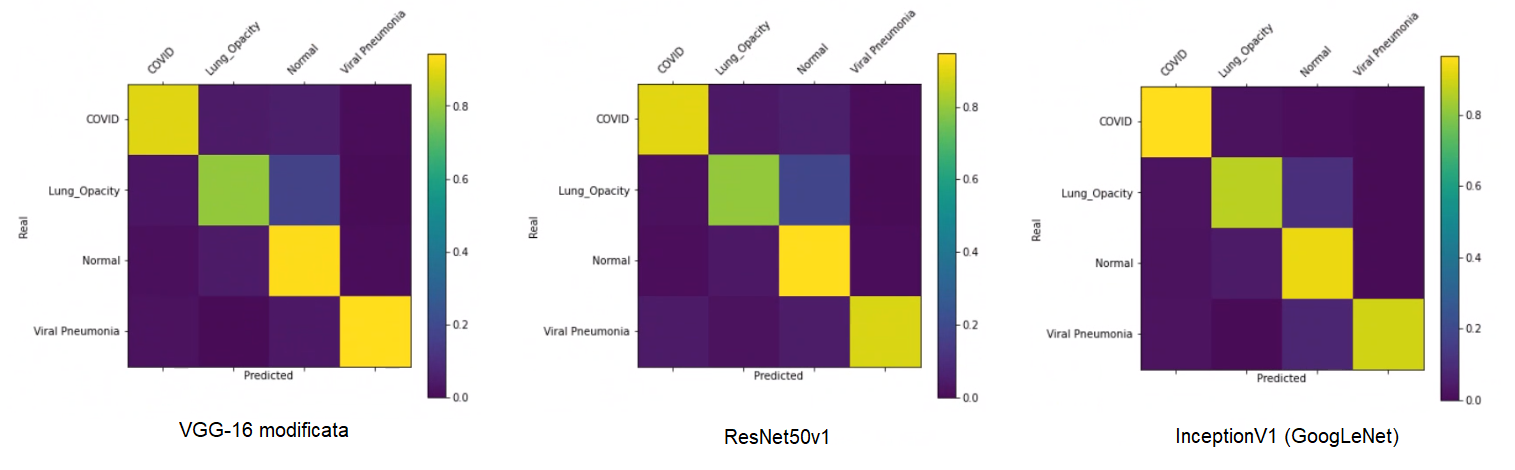

#### Confronto con altre soluzioni

Nell'implementare le soluzioni proposte si è fatto riferimento in particolare a paper trovati in letteratura. Il dataset scaricato ha dei notebook associati, non è stato comunque possibile confrontare i risultati ottenuti, con il codice disponibile su Kaggle, per diverse ragioni: il dataset veniva splittato in maniera differente (e spesso, soluzioni trovate in rete, non usavano il validation set), in alcuni casi veniva fatta data augmentation e i modelli erano preaddestrati.

### Errori/problematiche

La cella seguente mostra 20 immagini selezionate, in modo casuale, tra quelle classificate erroneamente; per la prediction con la quale si sono ottenute queste immagini si è usata la InceptionV1 (GoogLeNet) in quanto architettura migliore tra quelle implementate.

La maggior parte delle immagini mostrate non presenta particolari criticità che possano evidenziare la motivazione della classificazione errata o, comunque, la nostra conoscenza non è sufficiente per una diagnosi accurata in ambito medico.
In alcuni casi però si sono notate immagini orizzontali oppure immagini poco definite, alcune immagini inoltre sembrano fotografie di lastre in quanto presentano il bordo della radiografia.

Soluzioni proposte
* Siccome il covid colpisce i polmoni si suggerisce di focalizzare l'attenzione su di essi rimuovendo il rumore dato da altre porzioni di immagini non significative (collo, spalle, diaframma, bordo radiografia). [1]
* Applicare Histogram Equalization in modo da migliorare il contrasto nell'immagine [1]
* Applicare Data Augmentation sulle immagini del dataset in modo da rendere la rete più "robusta" nella classificazione di immagini orizzontali o ruotate. 


In [ ]:
predictions = get_predictions(googlenet, test_set_iterator)
plot_misclassified_images(test_set_iterator, predictions)

Si mostrano esempi di immagini non sufficientemente nitide oppure ruotate in orizzontale.

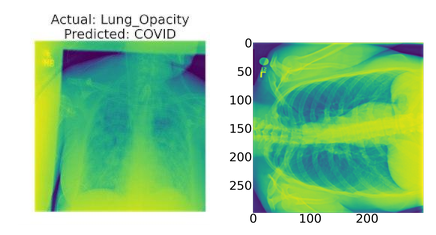

L'immagine mostra esempi di radiografie alle quali sono state applicate Histogram Equalization e Segmentation [1].

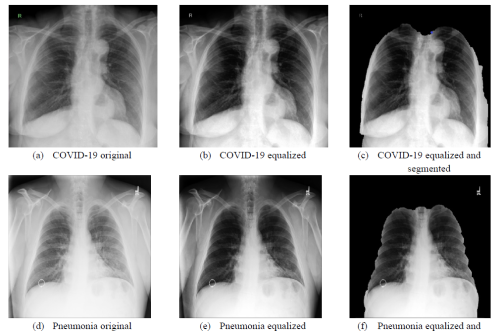

### Pulizia della sessione

Questa cella è fondamentale per eseguire il task di segmentation, in quanto libera la RAM, la GPU e il disco.

In [ ]:
shutil.rmtree(dataset_path)
shutil.rmtree('/content/splitted_dataset')
!kill -9 -1

### Riferimenti in letteratura

[1] X-Ray Image based COVID-19 Detection using Pre-trained Deep Learning Models - https://engrxiv.org/wx89s/

[2] Modified VGG Deep-Learning Architecture for Covid-19 Classification Using Chest Radiography images - https://www.bmbtrj.org/temp/BiomedBiotechnolResJ5143-5076427_140604.pdf

[3] Chest X-ray Classification Using Deep Learning for Automated COVID-19 Screening - https://link.springer.com/content/pdf/10.1007/s42979-021-00695-5.pdf

[4] Detection and Classification of COVID 19 using Convolutional Neural Network from Chest X-ray Images - https://ieeexplore.ieee.org/abstract/document/9418221

[5] Very Deep Convolutional Networks for Large-Scale Image Recognition - https://arxiv.org/abs/1409.1556

[6] Going deeper with convolutions - https://arxiv.org/pdf/1409.4842.pdf).

[7]Inception-v4, Inception-ResNet and
the Impact of Residual Connections on Learning - https://arxiv.org/pdf/1602.07261.pdf

[8]Deep Residual Learning for Image Recognition - https://arxiv.org/abs/1512.03385

[9]Identity Mappings in Deep Residual Networks - https://arxiv.org/abs/1603.05027

# Pneumothorax Semantic Segmentation

## Descrizione del problema
Il progetto ha l'obiettivo di identificare la porzione delle immagini rx in cui è presente lo pneumotorace, ovvero la presenza di aria nello spazio pleurico.

In Deep Learning i due principali approcci utilizzati per implementare la segmentazione sono:
1.   Semantic Segmentation: ogni pixel è classificato con una classe predifinita, in modo tale che ciascun pixel appartente alla stessa classe rappresentarà un'entità semantica nell'immagine.
 
2.   Instance Segmentation: simile alla Semantic Segmentation ma, identifica tutte le istanze di ciascuna entità semantica presente nell'immagine.

Nel presente notebook è stato utilizzato il primo approccio, essendo interessati all'indentificazione dell'entità pneumotorace piuttosto che alle sue istanze.

## Dataset
https://www.kaggle.com/firqaaa/beginer-guide-unet-for-image-segmentation/data

La scelta di utilizzare questo dataset, rispetto al dataset originale, è motivata dal fatto che le immagini rx e le maschere sono già codificate nel formato .png. Diversamente, nel dataset orginale (https://www.kaggle.com/seesee/full-dataset/data) le immagini sono codificate nel formato DICOM e le maschere con l'algoritmo Run-Length Encoding.

Il dataset originale divide le immagini in train e test, ma quelle relative al test sono solo polmoni sani, poco utile per il nostro scopo. Il dataset modificato, invece, divide il train set orginale in train e test.

Cardinalità: 12047 di cui 2669 sono immagini con pneumotorace.

Dimensione: 4.56GB.

## Import dei moduli

In [1]:
!pip install -q mlflow

In [2]:
import os
import cv2
import math
import shutil
import numpy as np
import pandas as pd
from glob import glob
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from math import log
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.activations import relu, softmax
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import add, AveragePooling2D, concatenate, Conv2D, BatchNormalization, Input, MaxPooling2D, SeparableConvolution2D, UpSampling2D, ZeroPadding2D

import random
from os.path import basename, dirname, join

import IPython
import mlflow

import warnings
warnings.filterwarnings('ignore')

## Utility functions

In questa cella sono state raggruppate varie funzioni utili nelle celle successive per mostrare sia i grafici delle metriche, successivamente l'addestramento, sia per mostrare le immagini (rx e maschere) nell'analisi esplorativa e nella ri-organizzazione del dataset.

In [111]:
def plot_history(history,metric=None):
  """
  Draws in a graph the loss trend over epochs on both training and validation
  sets. Moreover, if provided, it draws in the same graph also the trend of
  the given metric. 

  :param history: A History object. Its 'history' attribute is a record
      of training loss values ('loss') and metrics values at successive epochs,
      as well as validation loss values ('val_loss') and validation metrics
      values (if applicable).
  :param metric: The name of the plotted metric.
  """
  fig, ax1 = plt.subplots(figsize=(10, 8))

  epoch_count=len(history.history['loss'])

  line1,=ax1.plot(range(1,epoch_count+1),history.history['loss'],label='train_loss',color='orange')
  ax1.plot(range(1,epoch_count+1),history.history['val_loss'],label='val_loss',color = line1.get_color(), linestyle = '--')
  ax1.set_ylim([0, max(max(history.history['loss']),max(history.history['val_loss']))])
  ax1.set_ylabel('loss',color = line1.get_color())
  ax1.tick_params(axis='y', labelcolor=line1.get_color())
  _=ax1.legend(loc='lower left')

  if (metric!=None):
    ax2 = ax1.twinx()
    line2,=ax2.plot(range(1,epoch_count+1),history.history[metric],label='train_'+metric)
    ax2.plot(range(1,epoch_count+1),history.history['val_'+metric],label='val_'+metric,color = line2.get_color(), linestyle = '--')
    ax2.set_xlim([1,epoch_count])
    ax2.set_ylim([0, max(max(history.history[metric]),max(history.history['val_'+metric]))])
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel(metric,color=line2.get_color())
    ax2.tick_params(axis='y', labelcolor=line2.get_color())
    _=ax2.legend(loc='upper right')

  fig.savefig(metric + '_history.png')

def pie_chart(labels, sizes, explode):
  figure, axis = plt.subplots()
  axis.pie(sizes, explode, labels, autopct='%1.2f%%', shadow=True, startangle=90)
  axis.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
  plt.show()

def show_image_grid(image_path, grid_size, image_size, cmap='bone'):
  fig = plt.figure(figsize=image_size)
  rows, columns = grid_size
  for i in range(1, columns*rows +1):
      fn = np.random.choice(image_path)
      img = cv2.imread(fn)
      fig.add_subplot(rows, columns, i)
      plt.axis('off')
      plt.imshow(img, cmap=cmap)
  plt.show()

def overlay_image_mask(image, file, mask_filenames):
  mask_path = list(filter(lambda path: '/' + os.path.basename(file) in path, mask_filenames))[0]
  print(mask_path)
  mask = cv2.imread(mask_path)
  return cv2.addWeighted(image, 1, mask, 0.3, 0)

def compare_images(images, titles, file, image_size):
  number_of_images = len(images)
  
  fig, axes = plt.subplots(1, number_of_images, figsize=image_size)
  for i in range(number_of_images):
    axes[i].imshow(images[i], cmap='bone')
    axes[i].set_title(titles[i])
    axes[i].axis('off')
  plt.suptitle(f'Image: {file}')
  plt.show()

def show_predictions_and_ground_thruth(dataset_iterator, predictions):
  idx = random.randint(0, dataset_iterator.samples)

  image_path = dataset_iterator.filepaths[idx]
  mask_path = image_path.replace('images', 'masks')

  filename = basename(image_path)
  foldername = basename(dirname(image_path))

  image = cv2.imread(image_path)
  mask = cv2.imread(mask_path)
  mask_predicted = np.squeeze(predictions[idx])

  plt.figure(figsize=(40,9))
  plt.subplot(1,4,1)
  plt.imshow(image, 'bone')
  plt.title('X-ray scan')
  plt.axis('off')
  plt.subplot(1,4,2)
  plt.imshow(mask, 'bone')
  plt.title('Real mask')
  plt.axis('off')
  plt.subplot(1,4,3)
  plt.imshow(image, 'bone')
  plt.imshow(mask, 'Reds', alpha=0.3)
  plt.title('Real mask overlay to the image')
  plt.axis('off')
  plt.subplot(1,4,4)
  plt.imshow(mask_predicted, 'bone')
  plt.title('Predicted mask')
  plt.axis('off')
  plt.suptitle(f'Image: {filename} in {foldername}')
  plt.show()

In [4]:
def get_number_of_samples(pneumothorax=True):
  pneumothorax_df = pd.concat([train_df[train_df['has_pneumo'] == pneumothorax], test_df[test_df['has_pneumo'] == pneumothorax]])
  pneumothorax_indices = pneumothorax_df.index
  return len(pneumothorax_indices)

def get_percentage(part, total):
  return round(part/total*100, 2)

Le seguenti funzioni sono utili nella ri-organizzazione del dataset per creare lo *splitted_dataset* su cui effettuare la segmentation.

In [5]:
def copy_images(dataset, source, pneumothorax_destination, healthy_destination):
  for filename, id, label in dataset:
    image_path = os.path.join(source, filename)
    destination_directory = pneumothorax_destination if label else healthy_destination
    destination_path = os.path.join(destination_directory, filename)
    shutil.copyfile(image_path, destination_path)

def create_folder(destination):
  if not os.path.exists(destination):
    os.makedirs(os.path.dirname(destination))
    print(destination, " created")

Le seguenti funzioni sono utili peer caricare i modelli definitivi, su cui effettuare l'analisi delle prestazione, da GDrive.

In [6]:
#author: https://stackoverflow.com/a/39225039
import requests

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

In [7]:
def load_model(path):
  """
  Loads a model in such a way that its training can go on.
  :param path: The path of the model to be loaded.

  :return: The Keras model
  """
  return keras.models.load_model(path)

## Tracking e log degli esperimenti

A supporto dei molteplici esperimenti fatti è stato utilizzato [MLFlow](https://mlflow.org); questo tool permette di effettuare il log degli esperimenti di un progetto di Machine Learning (in generale). MLFlow è stato utilizzato, in questo progetto, per tenere traccia degli iperparametri utilizzati e delle metriche ottenute.

Nel codice dell'addestramento delle architetture si sono utilizzati i metodi mlflow.start_run(), mlflow.set_tag(), mlflow.tensorflow.autolog() e mlflow.end_run(). Le celle di codice sono state lasciate per mostrare come è stato fatto il log degli esperimenti, queste, però, sono commentate in quanto utilizzate solo per gli addestramenti.

La cella di codice seguente imposta l'uri del server nel quale sono stati salvati i log degli esperimenti e, l'ultima riga, mostra gli esperimenti fatti.

In [ ]:
REPO_NAME= "dl-project"
USER_NAME = "esalvucci"
os.environ['MLFLOW_TRACKING_USERNAME'] = 'esalvucci'
os.environ['MLFLOW_TRACKING_PASSWORD'] = 'c797c82f6b341e84671f23233ace1797e7a78d50'

mlflow.set_tracking_uri(f'https://dagshub.com/{USER_NAME}/{REPO_NAME}.mlflow')
display(IPython.display.IFrame(f"https://dagshub.com/{USER_NAME}/{REPO_NAME}/experiments/#/",'100%',600))

## Download dataset

In [8]:
zipped_dataset_path = "/content/dataset.zip" 
path_to_downloaded_file = tf.keras.utils.get_file(
    "/content/dataset.zip",
    "https://cerimoniale.net/sito/uploads/2021/05/dl-project/siim-acr-pneumothorax.zip")

!unzip -qq /content/dataset.zip -d /content/dataset/
!rm dataset.zip
complete_dataset=True

4825497600/4825496010 [==============================] - 137s 0us/step


## Analisi Esplorativa del Dataset

Insieme al dataset sono presenti due file .csv, in cui sono disponibili varie informazioni sul dataset, quali: presenza di pneumotorace, correlazione tra i nomi delle immmagini del dataset originale e di quello utilizzato.

Nelle celle successive vengono mostrate le prime 5 righe di entrambi i file .csv.

In [9]:
train_df = pd.read_csv('/content/dataset/stage_1_train_images.csv')
test_df = pd.read_csv('/content/dataset/stage_1_test_images.csv')

In [10]:
train_df.head()

new_filename  ... has_pneumo
0  0_train_0_.png  ...          0
1  1_train_0_.png  ...          0
2  2_train_1_.png  ...          1
3  3_train_1_.png  ...          1
4  4_train_1_.png  ...          1

[5 rows x 3 columns]

In [11]:
test_df.head()

new_filename                                            ImageId  has_pneumo
0  0_test_1_.png  1.2.276.0.7230010.3.1.4.8323329.5797.151787519...           1
1  1_test_0_.png  1.2.276.0.7230010.3.1.4.8323329.5798.151787519...           0
2  2_test_0_.png  1.2.276.0.7230010.3.1.4.8323329.5799.151787519...           0
3  3_test_0_.png  1.2.276.0.7230010.3.1.4.8323329.580.1517875163...           0
4  4_test_0_.png  1.2.276.0.7230010.3.1.4.8323329.5800.151787519...           0

Numero di immagini e di maschere presenti nel dataset, e delle immagini (con percentuali) di polmoni sani e con pneumotorace.

In [12]:
images_fns = sorted(glob('/content/dataset/png_images/*.png'))
masks_fns = sorted(glob('/content/dataset/png_masks/*.png'))

print("Total number of x-ray images: ", len(images_fns))
print("Total number of masks: ", len(masks_fns))

Total number of x-ray images:  12047
Total number of masks:  12047


Number of x-ray images of healthy lungs: 9378 (77.85%) of 12047
Number of x-ray images of lungs with pneumothorax: 2669 (22.15%) of 12047


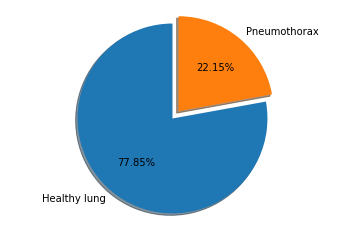

In [13]:
healthy_lung_samples = get_number_of_samples(pneumothorax=False)
pneumothorax_samples = get_number_of_samples()
total_samples = healthy_lung_samples + pneumothorax_samples

healthy_lung_size = get_percentage(healthy_lung_samples, total_samples)
pneumothorax_size = get_percentage(pneumothorax_samples, total_samples)

print(f"Number of x-ray images of healthy lungs: {healthy_lung_samples} ({healthy_lung_size}%) of {total_samples}")
print(f"Number of x-ray images of lungs with pneumothorax: {pneumothorax_samples} ({pneumothorax_size}%) of {total_samples}")

labels = 'Healthy lung', 'Pneumothorax'
sizes = healthy_lung_size, pneumothorax_size
explode = 0, 0.1

pie_chart(labels, sizes, explode)

### Visualizzazione campione di lastre rx

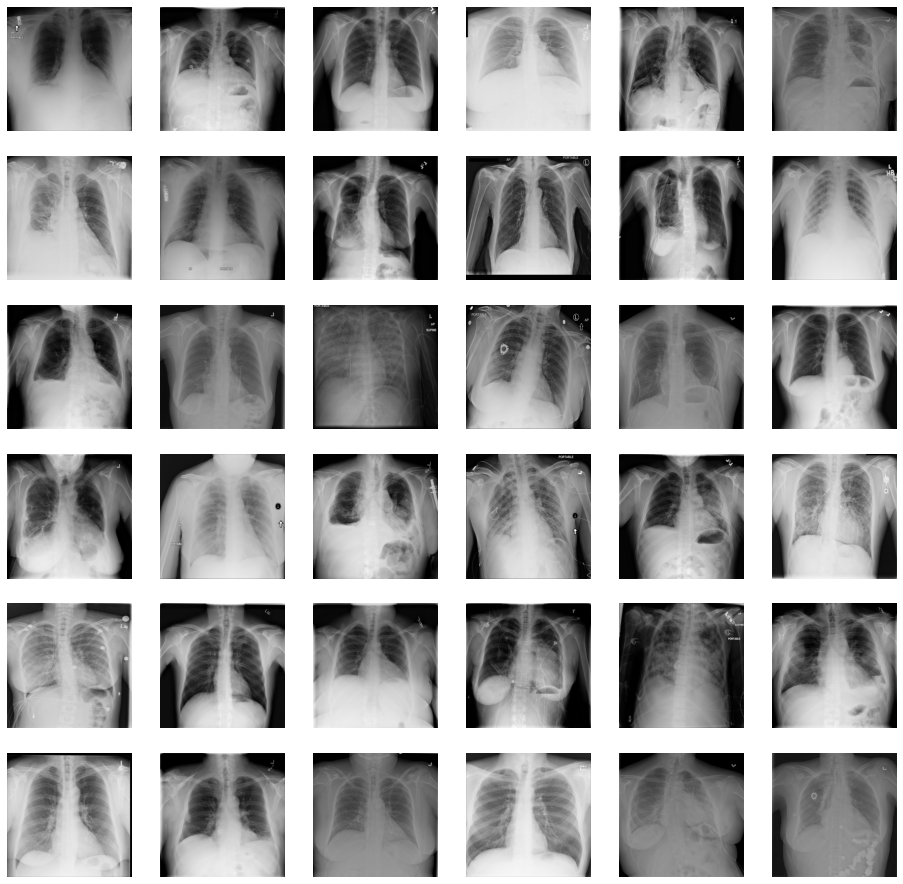

In [14]:
show_image_grid(image_path=images_fns, grid_size=(6, 6), image_size=(16, 16))

### Visualizzazione campione di maschere

/content/dataset/png_masks/1495_train_1_.png


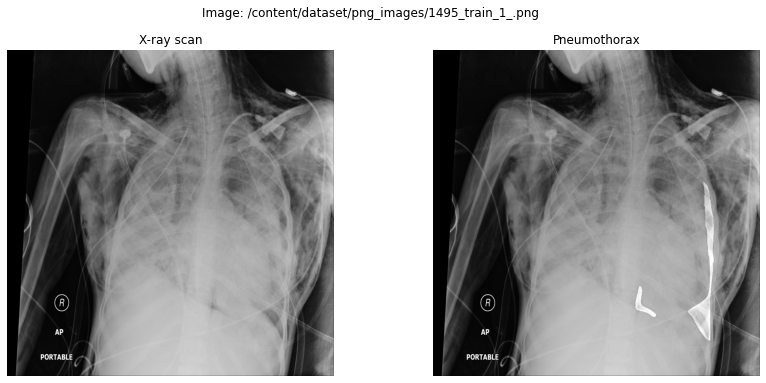

In [15]:
# for random image use: np.random.choice(images_fns)
# other useful image '/content/dataset/png_images/1010_test_1_.png'

file = '/content/dataset/png_images/1495_train_1_.png'
x = cv2.imread(file)

image2 = x
image_title = 'Healthy Lung'

if '_1_.png' in file:
  image2 = overlay_image_mask(x, file, masks_fns)
  image_title = 'Pneumothorax'

compare_images([x, image2], ['X-ray scan', image_title], file, (14, 6))

## Ri-organizzazione del dataset

Il dataset scaricato presenta due cartelle, una per le immagini rx e l'altra per le maschere.

Nella cella successiva, è stata effettuata una suddivisione, con l'utilizzo dei file .csv, in *train* e *test*. Al loro interno, sono state raggruppate le immagini in *images* e la maschere in *masks*. Inoltre, sia le immagini che le maschere, di ciascun set sono state raggruppate in *healthy* e *pneumothorax*.

Di seguito, è stata riportata una rappresentazione grafica della nuova struttura:
* /content/splitted_dataset/
  * train
    * images
      * healthy
      * pneumothorax
    * masks
      * healthy
      * pneumothorax
  * test
    * images
      * healthy
      * pneumothorax
    * masks
      * healthy
      * pneumothorax

In [16]:
image_source = '/content/dataset/png_images/'
masks_source = '/content/dataset/png_masks/'
healthy_train_destination = '/content/splitted_dataset/train/images/healthy/'
healthy_masks_train_destination = '/content/splitted_dataset/train/masks/healthy/'
healthy_test_destination = '/content/splitted_dataset/test/images/healthy/'
healthy_masks_test_destination = '/content/splitted_dataset/test/masks/healthy/'
pneumothorax_train_destination = '/content/splitted_dataset/train/images/pneumothorax/'
pneumothorax_masks_train_destination = '/content/splitted_dataset/train/masks/pneumothorax/'
pneumothorax_test_destination = '/content/splitted_dataset/test/images/pneumothorax/'
pneumothorax_masks_test_destination = '/content/splitted_dataset/test/masks/pneumothorax/'

create_folder(healthy_train_destination)
create_folder(healthy_masks_train_destination)
create_folder(healthy_test_destination)
create_folder(healthy_masks_test_destination)
create_folder(pneumothorax_train_destination)
create_folder(pneumothorax_masks_train_destination)
create_folder(pneumothorax_test_destination)
create_folder(pneumothorax_masks_test_destination)

copy_images(list(train_df.to_records(index=False)), image_source, pneumothorax_train_destination, healthy_train_destination)
copy_images(list(test_df.to_records(index=False)), image_source, pneumothorax_test_destination, healthy_test_destination)
copy_images(list(train_df.to_records(index=False)), masks_source, pneumothorax_masks_train_destination, healthy_masks_train_destination)
copy_images(list(test_df.to_records(index=False)), masks_source, pneumothorax_masks_test_destination, healthy_masks_test_destination)

shutil.copy2('/content/dataset/stage_1_train_images.csv', '/content/splitted_dataset/')
shutil.copy2('/content/dataset/stage_1_test_images.csv', '/content/splitted_dataset/')

/content/splitted_dataset/train/images/healthy/  created
/content/splitted_dataset/train/masks/healthy/  created
/content/splitted_dataset/test/images/healthy/  created
/content/splitted_dataset/test/masks/healthy/  created
/content/splitted_dataset/train/images/pneumothorax/  created
/content/splitted_dataset/train/masks/pneumothorax/  created
/content/splitted_dataset/test/images/pneumothorax/  created
/content/splitted_dataset/test/masks/pneumothorax/  created


'/content/splitted_dataset/stage_1_test_images.csv'

Eliminazione del dataset scaricato in precedenza al fine di ridurre l'utilizzo del disco.

In [17]:
shutil.rmtree('/content/dataset/')

### Split del dataset in train, validation e test set

Con l'obiettivo di identificare la porzione di immagine che contiene lo pneumotorace, nella cella seguente sono state eliminate le immagini dei polmoni sani. 

In [18]:
shutil.rmtree('/content/splitted_dataset/train/images/healthy')
shutil.rmtree('/content/splitted_dataset/train/masks/healthy')
shutil.rmtree('/content/splitted_dataset/test/images/healthy')
shutil.rmtree('/content/splitted_dataset/test/masks/healthy')
# complete_dataset=False # utile per settare il parametro complete_dataset in dagshub

La classe ImageDataGenerator permette di generare mini-batch di immagini; la classe può essere utilizzata anche per il preprocessing delle immagini (ed, eventualmente, anche fare data augmentation): attraverso ImageDataGenerator qui viene scalata l'intensità dei pixel in modo che rientri in un range [0, 1] invece che [0, 255] (per evitare che valori elevati rendano l'addestramento instabile).

Oltre ad instanziare un ImageDataGenerator, viene suddiviso il dataset in *training set*, *validation set* e *test set*.
Tutte le reti nelle loro architetture originali prendeno in input immagini a colori, quindi con 3 canali. In questo notebook sono satate, invece utilizzati immagini a scala di grigi, quindi con un solo canale.

Le reti sono addestrate da zero e, utilizzare 1 come valore per la *depth*, ci permette di ridurre il numero di pesi addestrabili senza inficiare la bontà dell'apprendimento, dato che le immagini di per sè non sono rgb.

In [8]:
batch_size=16
augmentation=False
target_size=(128, 128)
validation_set_size=0.1

data_gen_args = dict(target_size=target_size,
                      batch_size=batch_size,
                      color_mode='grayscale',
                      class_mode=None,
                      seed=42)

train_val_args = dict(rescale=1./255,
                         validation_split = validation_set_size)

if augmentation:
  augmentation_args = dict(rotation_range=30,
                         zoom_range=0.2,
                         width_shift_range=0.2,
                         height_shift_range=0.2,
                         shear_range=0.2,
                         horizontal_flip=True,
                         fill_mode="nearest",
                         rescale=1./255,
                         validation_split = validation_set_size)
  train_val_args.update(augmentation_args)

train_val_image_generator = ImageDataGenerator(**train_val_args)
train_val_mask_generator = ImageDataGenerator(**train_val_args)

test_image_generator = ImageDataGenerator(rescale=1./255)
test_mask_generator = ImageDataGenerator(rescale=1./255)

splitted_dataset_path = '/content/splitted_dataset/'

training_set_iterator = train_val_image_generator.flow_from_directory(
    splitted_dataset_path + 'train/images',
    **data_gen_args,
    subset='training'
)

training_mask_set_iterator = train_val_mask_generator.flow_from_directory(
    splitted_dataset_path + 'train/masks',
    **data_gen_args,
    subset='training'
)

validation_set_iterator = train_val_image_generator.flow_from_directory(
    splitted_dataset_path + 'train/images',
    **data_gen_args,
    subset='validation'
)

validation_mask_set_iterator = train_val_mask_generator.flow_from_directory(
    splitted_dataset_path + 'train/masks',
    **data_gen_args,
    subset='validation'
)

test_set_iterator = test_image_generator.flow_from_directory(
    splitted_dataset_path + 'test/images',
    **data_gen_args,
    shuffle=False
)

test_mask_set_iterator = test_mask_generator.flow_from_directory(
    splitted_dataset_path + 'test/masks',
    **data_gen_args,
    shuffle=False
)

training_iterator = zip(training_set_iterator, training_mask_set_iterator)
validation_iterator = zip(validation_set_iterator, validation_mask_set_iterator)
test_iterator = zip(test_set_iterator, test_mask_set_iterator)

Found 2142 images belonging to 1 classes.
Found 2142 images belonging to 1 classes.
Found 237 images belonging to 1 classes.
Found 237 images belonging to 1 classes.
Found 290 images belonging to 1 classes.
Found 290 images belonging to 1 classes.


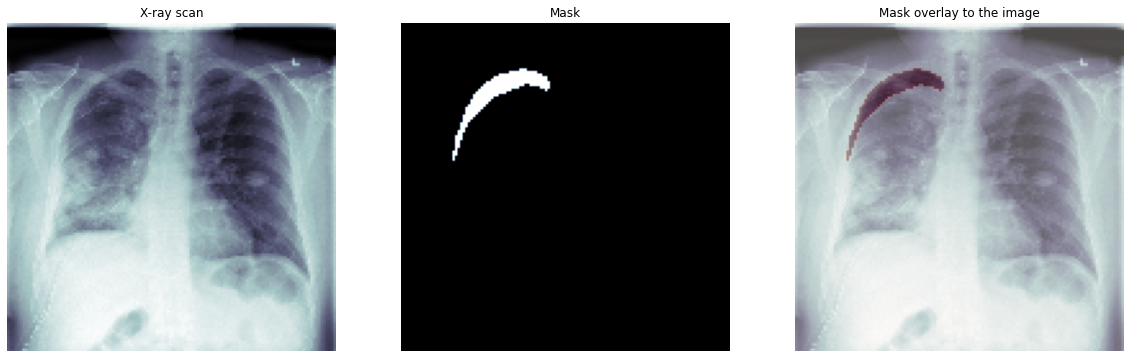

In [ ]:
for image_batch, mask_batch in training_iterator:
  image = np.squeeze(image_batch[0])
  mask = np.squeeze(mask_batch[0])

  plt.figure(figsize=(20,8))
  plt.subplot(1,3,1)
  plt.imshow(image, 'bone')
  plt.title('X-ray scan')
  plt.axis('off')
  plt.subplot(1,3,2)
  plt.imshow(mask, 'bone')
  plt.title('Mask')
  plt.axis('off')
  plt.subplot(1,3,3)
  plt.imshow(image, 'bone')
  plt.imshow(mask, 'Reds', alpha=0.3)
  plt.title('Mask overlay to the image')
  plt.axis('off')
  plt.show()

  break

## Metriche per la Segmentation

In letteratura[1], per la valutazione della segmentazione di immagini biomedicali, vengono principalmente utilizzate metriche basate sui pixel e sulle sovrapposizioni. Di seguito vengono riportate le metriche adottate per il nostro task.

<img src="https://miro.medium.com/max/644/1*yUd5ckecHjWZf6hGrdlwzA.png" width="300">

Il **dice coefficient**, o anche nota come F1-Score, calcola la similarità o la sovrapposizione tra due esempi del dataset, fornendo valori nell'intervallo [0, 1]. Più il valore è vicino all'1 e più la maschera predetta sarà simile alla maschera originale.

<img src="https://www.programmersought.com/images/396/1d37807676b252fd13c57ca101588ee4.png">

Un altro modo di raprresentare la formula è il seguente:

<img src="https://www.programmersought.com/images/292/1106a30ed27d34fada544211fa305bec.png">

---
<img src="https://miro.medium.com/max/450/0*kraYHnYpoJOhaMzq.png">

Lo **iou index**, anche noto come Jaccard index, calcola l'area di intersezione tra la maschera predetta e quella originale diviso l'area di unione tra le due.

<img src="https://miro.medium.com/max/800/1*6gyQVZrOT2Kkc_fNbyUyjw.png">

---

Come loss è stata utilizzata la *binary cross-entropy + dice*, ottenuta dalla combinazione della *binary cross-entropy* e della *dice distance*. 

La *dice distance* calcola la dissimilarità tra il ground thruth e la maschera predetta. E' il complementare del dice coefficient, ovvero *dice distance = 1 - dice*.






In [93]:
def iou_index(y_pred, y_true, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    
    intersection = K.sum(y_pred_f * y_true_f)
    total = K.sum(y_pred_f) + K.sum(y_true_f)
    union = total - intersection
    
    return (intersection + smooth) / (union + smooth)

def dice_coefficient(y_pred, y_true, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)

    intersection = K.sum(y_pred_f * y_true_f)
    return (2. * intersection + smooth) / (K.sum(y_pred_f) + K.sum(y_true_f) + smooth)

def dice_loss(y_pred, y_true, smooth=1e-6):
    return 1. - dice_coefficient(y_pred, y_true, smooth)

def bce_dice_loss(y_pred, y_true):
    return binary_crossentropy(y_pred, y_true) + dice_loss(y_pred, y_true)

In [69]:
metrics=['binary_accuracy', dice_coefficient, iou_index]

steps_per_epoch = math.ceil(training_set_iterator.samples/training_set_iterator.batch_size)
validation_steps = math.ceil(validation_set_iterator.samples/validation_set_iterator.batch_size)
training_args = dict(x=training_iterator,
                        steps_per_epoch=steps_per_epoch,
                        validation_data=validation_iterator,
                        validation_steps=validation_steps)

## DeepLabV3+

<img src="https://paperswithcode.com/media/models/Screen_Shot_2021-02-21_at_10.34.37_AM_kvOFts0.png">

**DeepLabV3+**[2] è una rete pensata per trarre beneficio sia dal **modulo Spatial Pyramid Pooling** sia dalla **struttura Encoder-Decoder** per il task di segmentazione. Il primo modulo permette di codificare le informazioni contestuali su diversa scala adottando filtri (o operazioni di pooling)  con diversi *(atrous) rate* e su vari *fields-of-view*, mentre la seconda struttura cattura i contorni dell’oggetto ripristinando gradualmente le informazioni spaziali.

Nel dettaglio, DeepLabV3+ estende **DeepLabV3**, proponendola come encoder ed inserendo un semplice ma efficace decoder. DeepLabV3+ adotta la **Depthwise Separable Convolution**, un tipo di convoluzione che ha lo stesso risultato di quella standard, a volte migliori, ma computazionalmente più efficiente.

**DeepLabV3**[3], invece, ha introdotto l’**Atrous Convolution**, o anche nota come *Dilated Convolution*, che consiste nell’allargare il *field-of-view* senza aumentare i parametri. Questa convoluzione è stata mantenuta in DeepLabV3+ ed utilizzata anche nella parte di decoder insieme alla Depthwise Separable Convolution.

DeepLabV3 ha modificato la backbone sostituendo la **Stride Convolution** degli ultimi blocchi (in base all’*output stride* desiderato), con l’**Atrous Convolution**.

Anche se non esplicitamente indicato nel paper di DeepLabV3+, ho sostituito sia la Stride Convolution sia l’Atrous Convolution della backbone con la Depth Separable Convolution e Atrous Depth Separable Convolution, dato le migliori performance computazionali.


### Encoder

**ResNet Backbone**

Per la segmentazione è stata adottata la ResNetV2, in linea con il paper, in quanto permette di avere dei miglioramenti sull'addestramento utilizzando la **full pre-activation**.

Se istanziata con i parametri di default si ha una ResNetV2-50 senza Atrous Convolution. E' possibile, però istanziare qualsiasi ResNetV2-N con o senza Atrous Convolution passando tutti i parametri.

Per l'applicazione dell'Atrous Convolution è fondamentale specificare l'*output stride*, ovvero la differenza tra le dimensioni spaziali dell'output della rete e quelle dell'input. Flessibilità che non tutte le reti per la segmentation offrono.

In [22]:
def convolution(name, number_of_feature_maps, filter_size=1, stride=1, dilation_rate=1, input=None):
  output = BatchNormalization()(input)
  output = relu(output)
  return SeparableConvolution2D(name=name, filters=number_of_feature_maps, kernel_size=filter_size, strides=stride, dilation_rate=(dilation_rate, dilation_rate), padding='same')(output)

def residual_function(name, filters, feature_maps, stride, dilation_rate, input):
  output, striding_layer = input, len(filters)-1

  for count, (filter_size, number_of_feature_maps) in enumerate(zip(filters, feature_maps), start=1):
    strides = stride if count == striding_layer else 1
    output = convolution(f'Conv_{count}_{name}', number_of_feature_maps, filter_size, strides, dilation_rate, output)
    print(output.shape)
  
  return output

def skip_connection(name, feature_maps, stride, input):
  if stride is None:
    return input
    
  return convolution(f'Conv_Shortcut_{name}', feature_maps, stride=stride, input=input)

def residual_block(name, filters, feature_maps, strides=(1, None), dilation_rate=1, input=None):
  f_x = residual_function(name, filters, feature_maps, strides[0], dilation_rate, input)
  x = skip_connection(name, feature_maps[-1], strides[1], input)
  output = add([f_x, x])
  return output

def residual_stage(name, number_of_units, filters, feature_maps, conv_strides, dilation_rate=None, multigrid=None, input=None):
  dilation_rates=[np.ones(number_of_units, dtype=int) if dilation_rate is None else dilation_rate*multigrid][0]
  strides = [conv_strides, *((1, None), )* (number_of_units-1)]
  output = input

  for i in range(number_of_units):
    print(f'Block_{i+1}_{name}', strides[i])
    output = residual_block(f'Block_{i+1}_{name}', filters, feature_maps, strides[i], dilation_rate=dilation_rates[i], input=output)
  return output

def reduction_stages(output_stride):
  return int(log(output_stride) / log(2) - 1)

def resnetv2(name='ResNetV2-50',
             shape=(224, 224, 3),
             number_of_units=[3, 4, 6, 3],
             filters=[1, 3, 1],
             feature_maps=[[64, 64, 256], [128, 128, 512], [256, 256, 1024], [512, 512, 2048]],
             output_stride=None,
             dilation_rates=None,
             multigrid=None):
  
  input = Input(shape=shape, name='Input')
  print("Input: ", input.shape)
  
  output = convolution("Conv_0", 64, 7, 2, input=input)
  print("Conv2D: ", output.shape)

  output = ZeroPadding2D()(output)
  output = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(output)
  print("MaxPooling2D: ", output.shape)
  
  low_level_features = residual_stage("Stage_1", number_of_units[0], filters, feature_maps[0], conv_strides=(1, 1), input=output)
  output = low_level_features
  print(f'Stage 1: {output.shape}')

  number_of_stages = reduction_stages(output_stride) if output_stride else 4

  # standard striding stages
  for i in range(1, number_of_stages):
    output = residual_stage(f'Stage_{i+1}', number_of_units[i], filters, feature_maps[i], conv_strides=(2, 2), input=output)
    print(f'Stage {i+1}: {output.shape}')

  # atrous stages
  for i in range(number_of_stages, 4):
    atrous_index = i % (4 - number_of_stages)
    output = residual_stage(f'Stage_{i+1}', number_of_units[i], filters, feature_maps[i], conv_strides=(1, 1), dilation_rate=dilation_rates[atrous_index], multigrid=multigrid[atrous_index], input=output)
    print(f'Stage {i+1}: {output.shape}')
    
  return low_level_features, Model(name=name, inputs=input, outputs=output)

**Atrous Spatial Pyramid Pooling (ASPP)**

Il modulo ASPP implementato fa uso della Atrous (Depthwise Separable) Convolution, come indicato nel paper della rete DeepLabV3+.

ASPP è formato da livelli paralleli di Atrous (Depthwise Separable) Convolution, ognuno con diverso atrous rate al fine di catturare le informazioni su varia scala. Mentre per catturare le informazioni relative al contesto globale, vi è un livello di pooling. I risultati vengono concatenati e applicato un ulteriore livello di convoluzione per ottenere i logits.

In [23]:
def image_level_pooling(input):
  output = AveragePooling2D()(input)
  print("Average Pooling: ", output.shape)
  output = BatchNormalization()(output)
  output = relu(output)
  output = SeparableConvolution2D(filters=256, kernel_size=(1,1))(output) # padding='same'
  print("Stride Convolution: ", output.shape)
  upsampling_size = int(input.shape[1]/output.shape[1])
  return UpSampling2D(size=(upsampling_size, upsampling_size), interpolation='bilinear')(output)

def concatenation(inputs):
  print(inputs)
  concatenation = concatenate(inputs)
  norm = BatchNormalization()(concatenation)
  act = relu(norm)
  conv_conc = SeparableConvolution2D(filters=256, kernel_size=(1,1))(act)
  return norm

def atrous_spatial_pyramid_pooling(input, dilation_rates=[6, 12, 18]):
  print("ASPP input: ", input.shape)
  output = BatchNormalization()(input)
  act = relu(output)
  
  conv1 = SeparableConvolution2D(filters=256, kernel_size=(1,1))(act)
  
  conv2 = SeparableConvolution2D(filters=256, kernel_size=(3,3), dilation_rate=dilation_rates[0], padding='same')(act)

  conv3 = SeparableConvolution2D(filters=256, kernel_size=(3,3), dilation_rate=dilation_rates[1], padding='same')(act)

  conv4 = SeparableConvolution2D(filters=256, kernel_size=(3,3), dilation_rate=dilation_rates[2], padding='same')(act)
  
  image_level_feature = image_level_pooling(act)
  print("Image level pooling: ", image_level_feature.shape)

  final_concatenation = concatenation([image_level_feature, conv4, conv3,  conv2, conv1])
  print("Concatenation: ", final_concatenation.shape)
  return final_concatenation

**DeepLabV3**

DeepLabV3 è una rete a sé stante utilizzata per task di segmentation ma, in questo caso, viene usata come encoder della rete DeepLabV3+.

In [24]:
def deeplabv3(backbone, number_of_classes, image_shape):
  backbone_aspp = atrous_spatial_pyramid_pooling(backbone.output)
  return Model(backbone.input, outputs=backbone_aspp)

### Decoder

Il decoder ha due scopi:
* rendere più chiari i bordi dell'oggetto, concatenando il risultato dell'encoder alle feature maps dei primissimi livelli della backbone.
* aumentare le dimensioni spaziali delle feature maps, riportandolo a quelle originali.

Per il secondo punto vi sono due livelli di up-sampling, il primo aumenta le dimensioni spaziali dell'output dell'encoder, il secondo dell'output del decoder.

In [25]:
def deeplabv3plus(low_level_features, encoder, output_stride=16, upsampling=4):

  output = BatchNormalization()(low_level_features)
  output = relu(output)
  conv = SeparableConvolution2D(filters=48, kernel_size=(1, 1), padding='same')(output)
  print("1x1 Convolution: ", conv.shape)

  upsampling_size = output_stride/upsampling
  upsampling_layer = UpSampling2D(size=(upsampling_size, upsampling_size), interpolation='bilinear')(encoder.output)
  print("Upsampling with bilinear interpolation: ", upsampling_layer.shape)

  concatenation = concatenate([conv, upsampling_layer])
  print("Concatenation of low and high level features: ", concatenation.shape)

  output = BatchNormalization()(concatenation)
  output = relu(output)
  output = SeparableConvolution2D(filters=256, kernel_size=(3, 3), padding='same')(output)
  print("3x3 Convolution: ", output.shape)

  output = BatchNormalization()(output)
  output = relu(output)
  output = SeparableConvolution2D(filters=1, kernel_size=(1, 1), padding='same')(output)
  
  upsampling_logits = UpSampling2D(size=(upsampling, upsampling), interpolation='bilinear')(output)
  print("Upsampling with bilinear interpolation: ", upsampling_logits.shape)

  return Model(encoder.input, keras.activations.sigmoid(upsampling_logits))

### Creazione del modello

In [26]:
# Common settings for all ResNet.
common_settings = dict(shape=training_set_iterator.image_shape,
                        output_stride=16,
                        dilation_rates=[2])

# Common settings to deep ResNets (50, 101, 152)
common_settings['multigrid'] = [[1, 2, 4]]

# Common settings to shallow ResNets (18, 34)
# common_settings['multigrid'] = [[2, 4]]

# Use only the common and default settings for ResNet-50.

# Settings for ResNet-101, to be added to the common ones.
# common_settings['number_of_units'] = [3, 4, 23, 3]

# Settings for ResNet-152, to be added to the common ones.
# common_settings['number_of_units'] = [3, 8, 36, 3]

# Settings for ResNet-18, to be added to the common ones.
# common_settings['filters']=[3, 3]
# common_settings['number_of_units'] = [2, 2, 2, 2]
# common_settings['feature_maps']=[[64, 64], [128, 128], [256, 256], [512, 512]]

low_level_features, backbone = resnetv2(**common_settings)
deeplabv3_model = deeplabv3(backbone, 1, target_size)
deeplabv3plus_model = deeplabv3plus(low_level_features, deeplabv3_model)

Input:  (None, 128, 128, 1)
Conv2D:  (None, 64, 64, 64)
MaxPooling2D:  (None, 32, 32, 64)
Block_1_Stage_1 (1, 1)
(None, 32, 32, 64)
(None, 32, 32, 64)
(None, 32, 32, 256)
Block_2_Stage_1 (1, None)
(None, 32, 32, 64)
(None, 32, 32, 64)
(None, 32, 32, 256)
Block_3_Stage_1 (1, None)
(None, 32, 32, 64)
(None, 32, 32, 64)
(None, 32, 32, 256)
Stage 1: (None, 32, 32, 256)
Block_1_Stage_2 (2, 2)
(None, 32, 32, 128)
(None, 16, 16, 128)
(None, 16, 16, 512)
Block_2_Stage_2 (1, None)
(None, 16, 16, 128)
(None, 16, 16, 128)
(None, 16, 16, 512)
Block_3_Stage_2 (1, None)
(None, 16, 16, 128)
(None, 16, 16, 128)
(None, 16, 16, 512)
Block_4_Stage_2 (1, None)
(None, 16, 16, 128)
(None, 16, 16, 128)
(None, 16, 16, 512)
Stage 2: (None, 16, 16, 512)
Block_1_Stage_3 (2, 2)
(None, 16, 16, 256)
(None, 8, 8, 256)
(None, 8, 8, 1024)
Block_2_Stage_3 (1, None)
(None, 8, 8, 256)
(None, 8, 8, 256)
(None, 8, 8, 1024)
Block_3_Stage_3 (1, None)
(None, 8, 8, 256)
(None, 8, 8, 256)
(None, 8, 8, 1024)
Block_4_Stage_3 (1, 

### Visualizzazione del modello

**Visualizzazione testuale**

In [27]:
deeplabv3plus_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 1)  4           Input[0][0]                      
__________________________________________________________________________________________________
tf.nn.relu (TFOpLambda)         (None, 128, 128, 1)  0           batch_normalization[0][0]        
__________________________________________________________________________________________________
Conv_0 (SeparableConv2D)        (None, 64, 64, 64)   177         tf.nn.relu[0][0]                 
____________________________________________________________________________________________

**Visualizzazione grafica**

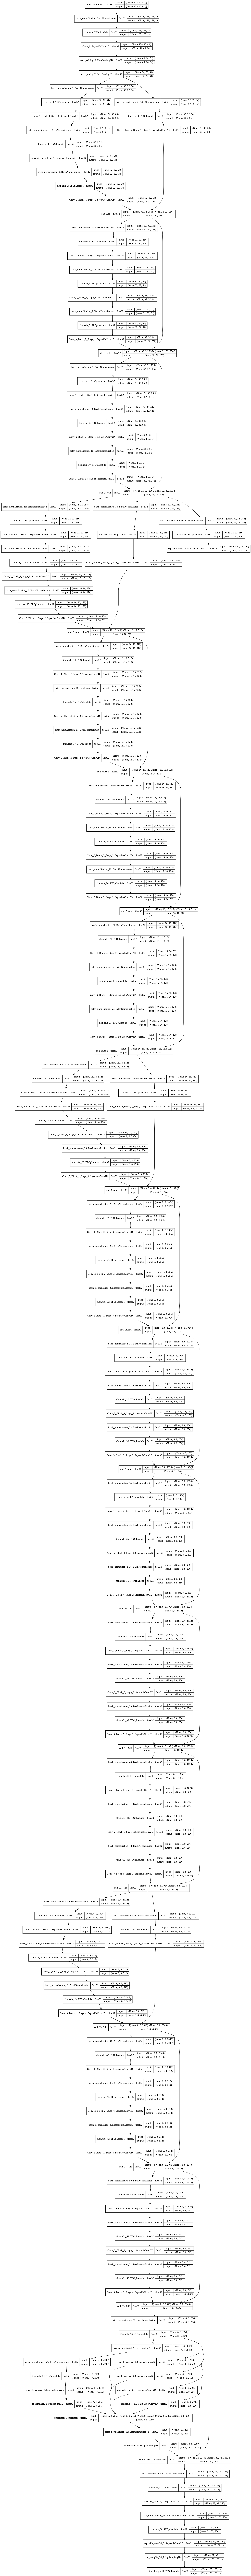

In [28]:
plot_model(deeplabv3plus_model, show_shapes=True, show_dtype=True)

### Training

Definizione Iperparametri



In [30]:
epochs=100
learning_rate=0.01
loss = bce_dice_loss
optimizer=keras.optimizers.Nadam(learning_rate=learning_rate)

In [31]:
stop_patience=5
decay_on_plateau_patience=3
early_stopping = EarlyStopping(patience=stop_patience, restore_best_weights=True)
decay_on_plateau = ReduceLROnPlateau(monitor='val_loss', factor=0.20, min_delta=1e-15, patience=decay_on_plateau_patience, verbose=1, mode='auto')

Avvio del training con memorizzazione degli iper-parametri e dei risultati delle metriche e della loss su dagshub.

In [ ]:
# mlflow.start_run()

# Set the name of the model and the type of the dataset used (False=only pneumothorax, True=healthy+pneumothorax) in the experiment tracker
# mlflow.set_tag('model_name', 'deeplabv3+')
# mlflow.set_tag('complete_dataset', complete_dataset)
# mlflow.set_tag('augmentation', False)
# mlflow.set_tag('loss name', loss.__name__)

# Autologs all the parameters, the metrics used in the training
# mlflow.tensorflow.autolog()

In [32]:
deeplabv3plus_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
history = deeplabv3plus_model.fit(**training_args, epochs=epochs, callbacks=[decay_on_plateau, early_stopping])
# mlflow.end_run()

Visualizzazione delle metriche.

In [ ]:
plot_history(history, metric='dice_coefficient')
plot_history(history, metric='iou_index')

## U-Net

![alt text](https://media.springernature.com/lw685/springer-static/image/art%3A10.1007%2Fs11554-020-01028-0/MediaObjects/11554_2020_1028_Fig4_HTML.png)

L'architettura U-Net è composta da due percorsi:
* *percorso di contrazione - contraction path* (lato sinistro): consiste nell'applicazione ripetuta di due livelli di convoluzione 3x3 seguti da Relu e da un livello max pooling.
* *percorso di espansione - expanding path* (lato destro): utilizza le convoluzioni trasposte

Ad ogni passo di downsampling raddoppiano il numero di feature channel, ad ogni passo di up-sampling dimezza il numero di feature channel.

Ogni up-sampling layer del contraction path riceve i dati dal corrispondete down sampling layer dell’expanding path.


Di seguito vengono mostrate due funzioni che saranno utilizzate dall'architettura U-Net.

La funzione *ConvBlock* racchiude:
* convolutional layer
* BatchNormalization (opzionale, non presente nel paper originale [4] )
* Relu

*up_conv_and_concatenate* viene utilizzato dal percorso di espansione e contiene un livello convoluzionale trasposto e lo concatena con il layer passato in input, proveniente dal percorso di contrazione. 

In [ ]:
def convBlock(input, filters, kernel_size=3, padding='same', activation=None, name=None):
  conv_block =layers.Conv2D(filters= filters, kernel_size=kernel_size, activation=activation, padding=padding)(input)
  conv_block = layers.BatchNormalization()(conv_block)
  conv_block =layers.Activation('relu')(conv_block)
  conv_block =layers.Conv2D(filters= filters, kernel_size=kernel_size, activation=activation, padding=padding, name=name)(conv_block)
  conv_block = layers.BatchNormalization()(conv_block)
  conv_block = layers.Activation('relu')(conv_block)
  return conv_block
  
def up_conv_and_concatenate(input, filters_conv2Dtraspose, concatenate_layer, name= None):
  up_conv=layers.Conv2DTranspose(filters= filters_conv2Dtraspose, kernel_size=(3, 3), strides=(2, 2), padding='same')(input)
  concat =layers.Concatenate(axis=-1)([concatenate_layer, up_conv])
  return concat

In [ ]:
def u_net(input_shape=(128,128,1)):
  filters=16
  input= layers.Input(shape=input_shape,name='Input')

  conv1= convBlock(input, filters=filters)
  pool1 = layers.MaxPool2D(pool_size=(2, 2), strides=2)(conv1) 
  conv2= convBlock(pool1, filters=filters * 2)
  pool2 = layers.MaxPool2D(pool_size=(2, 2), strides=2)(conv2)
  conv3= convBlock(pool2, filters=filters * 4)
  pool3 = layers.MaxPool2D(pool_size=(2, 2), strides=2)(conv3)
  conv4= convBlock(pool3, filters=filters * 8)
  pool4 = layers.MaxPool2D(pool_size=(2, 2), strides=2)(conv4)

  conv5= convBlock(pool4, filters= filters * 16)

  concat1 = up_conv_and_concatenate(conv5,filters_conv2Dtraspose= filters * 8, concatenate_layer= conv4, name= 'concatenate_1')
  conv4_dec= convBlock(concat1, filters= filters * 8)
  concat2 = up_conv_and_concatenate(conv4_dec,filters_conv2Dtraspose= filters * 4, concatenate_layer= conv3, name= 'concatenate_2')
  conv3_dec= convBlock(concat2, filters= filters* 4)
  concat3 = up_conv_and_concatenate(conv3_dec,filters_conv2Dtraspose= filters * 2, concatenate_layer= conv2, name= 'concatenate_3')
  conv2_dec = convBlock(concat3, filters=filters * 2)
  concat4 = up_conv_and_concatenate(conv2_dec,filters_conv2Dtraspose= filters, concatenate_layer= conv1, name= 'concatenate_4')
  conv1_dec = convBlock(concat4, filters= filters)

  #conv1x1
  output= layers.Conv2D(filters=1, kernel_size=1, padding='same', activation='sigmoid')(conv1_dec)

  model = keras.Model(inputs=[input], outputs=[output], name="u-net") 

  return model

###Creazione del modello

In [ ]:
unet_model = u_net()

Visualizzazione del modello

Model: "u-net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 160         Input[0][0]                      
__________________________________________________________________________________________________
batch_normalization_4 (BatchNor (None, 128, 128, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 128, 16) 0           batch_normalization_4[0][0]      
______________________________________________________________________________________________

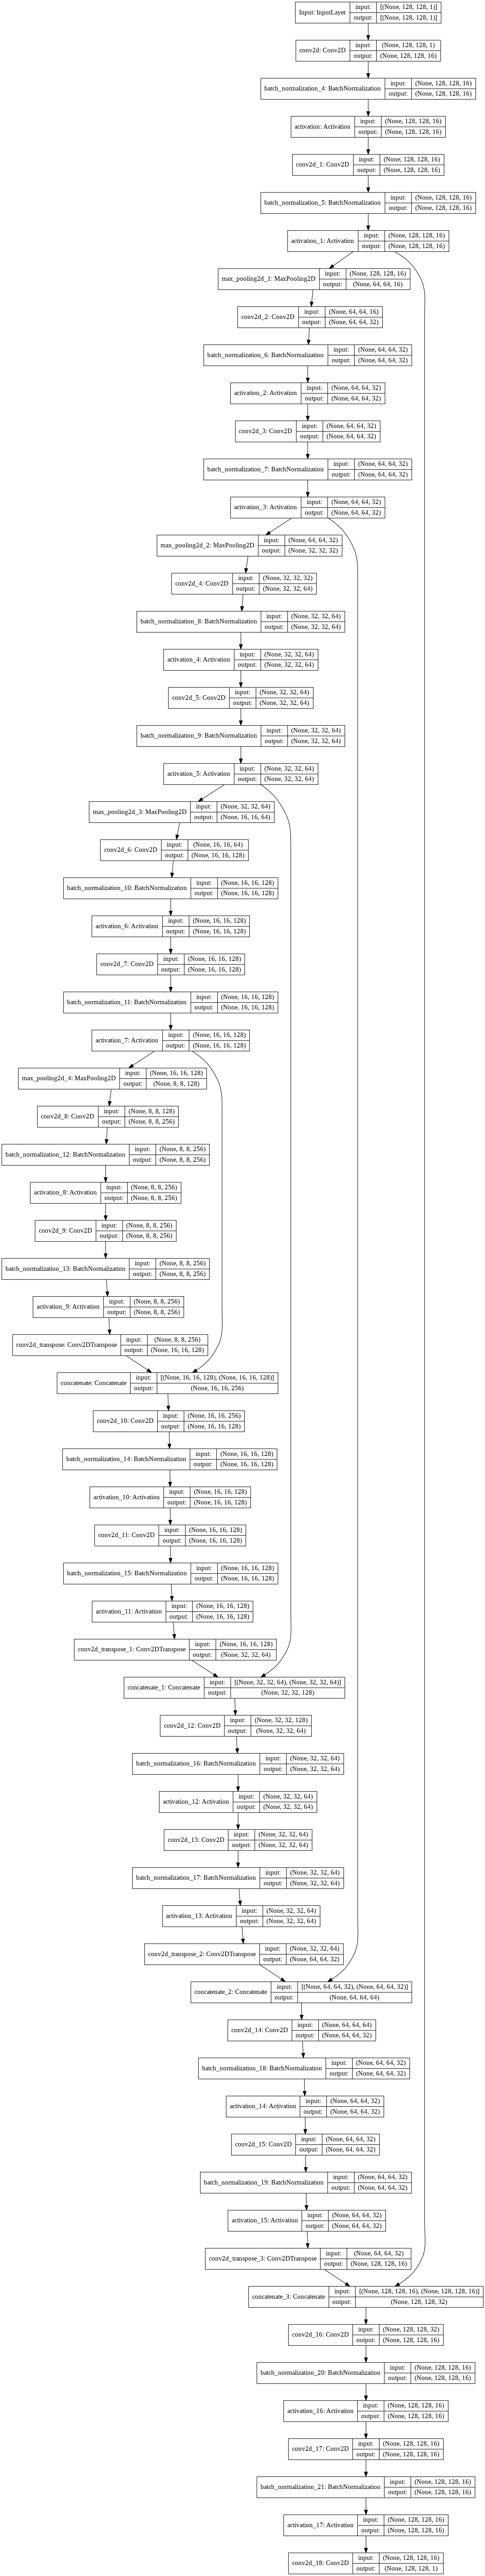

In [ ]:
unet_model.summary()
plot_model(unet_model, to_file='model.png',show_shapes= True)

###Impostazione iper-parametri e training

In [ ]:
loss = bce_dice_loss
optimizer= keras.optimizers.Adam(learning_rate=0.001)

La seguente cella serve per memorizzare gli iper-parametri, i risultati delle metriche e della loss su dagshub durante il training.

In [ ]:
#mlflow.start_run()

# Set the name of the model and the number of classes in the experiment tracker
#mlflow.set_tag('model_name', 'unet')
#mlflow.set_tag('complete_dataset', complete_dataset)
#mlflow.set_tag('augmentation', augmentation)
#mlflow.set_tag('loss name', loss.__name__)

# Autologs all the parameters, the metrics used in the training
#mlflow.tensorflow.autolog()

In [ ]:
unet_model.compile(
    optimizer=optimizer, 
    loss=bce_dice_loss,
    metrics=metrics
)

In [ ]:
stop_patience=5
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=stop_patience, restore_best_weights=True)

reduceLROnPlat = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.20, min_delta=1e-15, patience=3, 
                                   verbose=1, mode='auto')

callbacks=[reduceLROnPlat,early_stopping]
epochs=50

history = unet_model.fit(**training_args, epochs=epochs, callbacks=callbacks)
#mlflow.end_run()

Epoch 1/50
134/134 [==============================] - 72s 286ms/step - loss: 1.1748 - binary_accuracy: 0.9748 - dice_coefficient: 0.0427 - iou_index: 0.0219 - val_loss: 1.2599 - val_binary_accuracy: 0.9178 - val_dice_coefficient: 0.0353 - val_iou_index: 0.0180
Epoch 2/50
134/134 [==============================] - 36s 272ms/step - loss: 0.9936 - binary_accuracy: 0.9729 - dice_coefficient: 0.1134 - iou_index: 0.0604 - val_loss: 1.0225 - val_binary_accuracy: 0.9861 - val_dice_coefficient: 0.0511 - val_iou_index: 0.0262
Epoch 3/50
134/134 [==============================] - 34s 254ms/step - loss: 0.8673 - binary_accuracy: 0.9769 - dice_coefficient: 0.2097 - iou_index: 0.1179 - val_loss: 0.9475 - val_binary_accuracy: 0.9688 - val_dice_coefficient: 0.1467 - val_iou_index: 0.0794
Epoch 4/50
134/134 [==============================] - 35s 266ms/step - loss: 0.7865 - binary_accuracy: 0.9799 - dice_coefficient: 0.2846 - iou_index: 0.1671 - val_loss: 0.9876 - val_binary_accuracy: 0.9882 - val_dice_

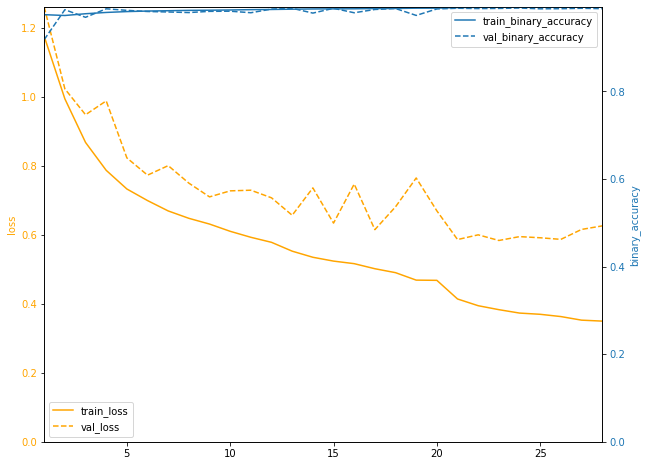

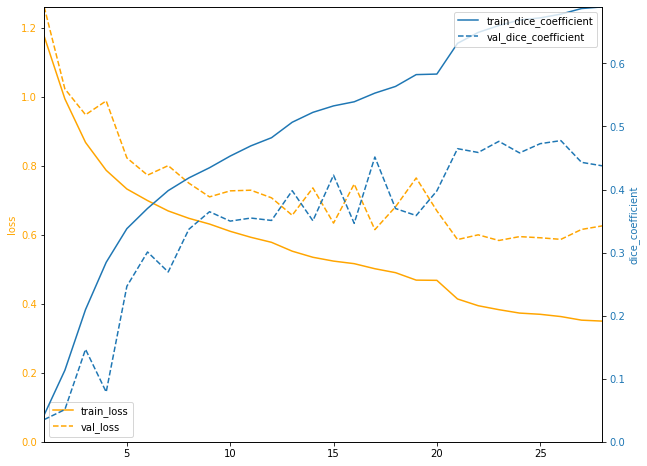

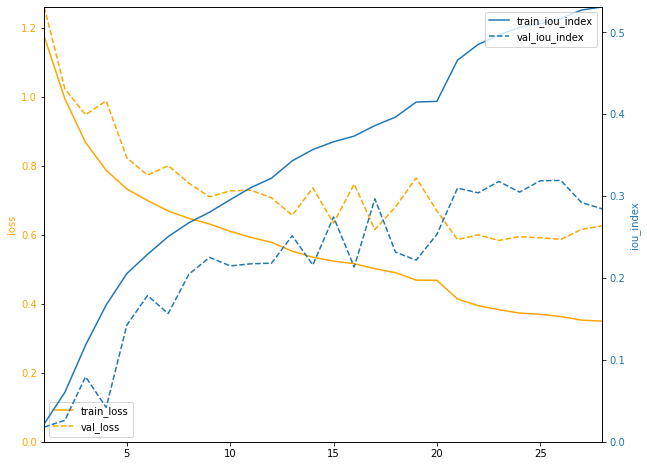

In [ ]:
plot_history(history, metric='binary_accuracy')
plot_history(history, metric='dice_coefficient')
plot_history(history, metric='iou_index')

## Analisi delle prestazioni

In [103]:
test_steps = math.ceil(test_set_iterator.samples / test_set_iterator.batch_size)

### DeepLab

Download del modello pre-addestrato e successivo caricamento.

In [95]:
deeplab_file_id = '105JJjF4x9ZMQPRdOHgl9ya--RT7Uqzkx'
trained_deeplab_path = '/content/deeplabv3plus.h5'

download_file_from_google_drive(deeplab_file_id, trained_deeplab_path)
deeplabv3plus_model = keras.models.load_model(trained_deeplab_path, custom_objects={'bce_dice_loss': bce_dice_loss, 'dice_coefficient': dice_coefficient, 'iou_index': iou_index})
deeplabv3plus_model.compile(optimizer=keras.optimizers.Nadam(learning_rate=0.01), loss=bce_dice_loss, metrics=metrics)
os.remove(trained_deeplab_path)

Valutazizone del modello pre-addestrato che utilizza Nadam come ottimizzatore, learning rate 0.01 ottenendo nel validation set circa 40% di Dice Coefficient, 25% di IoU index, 98% di Binary Accuracy e 0.66 di loss. In Test Set circa 38% di Dice Coefficient, 24% di IoU index, 98% di Binary Accuracy e 0.69 di loss.

In [106]:
loss_error, accuracy, dice_coef, iou = deeplabv3plus_model.evaluate(x=validation_iterator, batch_size=training_set_iterator.batch_size, verbose=0, steps=validation_steps)
print('Validation Set - Loss: {:.3f} Binary Accuracy: {:.3f} Dice Coefficient: {:.3f} IoU index: {:.3f}'.format(loss_error, accuracy, dice_coef, iou))

Validation Set - Loss: 0.663 Binary Accuracy: 0.985 Dice Coefficient: 0.402 IoU index: 0.257


In [98]:
loss_error, accuracy, dice_coef, iou = deeplabv3plus_model.evaluate(test_iterator, batch_size=training_set_iterator.batch_size, verbose=0, steps=test_steps)
print('Test Set - Loss: {:.3f} Binary Accuracy: {:.3f} Dice Coefficient: {:.3f} IoU index: {:.3f}'.format(loss_error, accuracy, dice_coef, iou))

Test Set - Loss: 0.698 Binary Accuracy: 0.984 Dice Coefficient: 0.386 IoU index: 0.243


### UNet

Download del modello pre-addestrato e successivo caricamento

In [99]:
unet_file_id = '1-9qCdt3AP8z9BYg445NBf9FsgktroYbv'
trained_unet_path = '/content/unet.h5'

download_file_from_google_drive(unet_file_id, trained_unet_path)
unet_model = keras.models.load_model(trained_unet_path, custom_objects={'bce_dice_loss': bce_dice_loss, 'dice_coefficient': dice_coefficient, 'iou_index': iou_index})
unet_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss=bce_dice_loss, metrics=metrics)
os.remove(trained_unet_path)

Valutazione del modello pre-addestrato che utilizza Adam come ottimizzatore, learning rate di 0.001 ottenendo nel validation set circa 47% di Dice Coefficient, 31% di Iou index, 99% di Binary Accuracy e 0.57 di loss.
In Test Set circa 43% di Dice Coefficient, 28% di IoU index, 98% di Binary Accuracy e 0.63 di loss.


In [101]:
loss_error, accuracy, dice_coef, iou = unet_model.evaluate(validation_iterator, batch_size=training_set_iterator.batch_size, verbose=0, steps=validation_steps)
print('Validation Set - Loss: {:.3f} Binary Accuracy: {:.3f} Dice Coefficient: {:.3f} IoU index: {:.3f}'.format(loss_error, accuracy, dice_coef, iou))

Validation Set - Loss: 0.575 Binary Accuracy: 0.990 Dice Coefficient: 0.476 IoU index: 0.319


In [105]:
loss_error, accuracy, dice_coef, iou = unet_model.evaluate(test_iterator, batch_size=training_set_iterator.batch_size, verbose=0, steps=test_steps)
print('Test Set - Loss: {:.3f} Binary Accuracy: {:.3f} Dice Coefficient: {:.3f} IoU index: {:.3f}'.format(loss_error, accuracy, dice_coef, iou))

Test Set - Loss: 0.630 Binary Accuracy: 0.988 Dice Coefficient: 0.433 IoU index: 0.283


### UNet++

Download del modello pre-addestrato e successivo caricamento.
L'implentazione e la scelta degli iper-parametri sono stati presi dal [notebook kaggle](https://www.kaggle.com/firqaaa/beginer-guide-unet-for-image-segmentation/notebook), da cui è stato estratto il dataset.

Il dataset utilizzato per il confronto delle varie architetture è comune, come anche le metriche. Essendo, però, le metriche del notebook matematicamente non coerenti tra loro si è scelto di utilizzare le nostre implementazioni.

In [107]:
unet_file_id = '1--qBdBj9inGSyK9zDg7gOiPXG5Sh67Vf'
trained_unet_path = '/content/unetplusplus.h5'

download_file_from_google_drive(unet_file_id, trained_unet_path)
unet_model = keras.models.load_model(trained_unet_path, custom_objects={'bce_dice_loss': bce_dice_loss, 'dice_coefficient': dice_coefficient, 'iou_index': iou_index})
unet_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.00001), loss=bce_dice_loss, metrics=metrics)
os.remove(trained_unet_path)

Valutazione del modello pre-addestrato che utilizza Adam come ottimizzatore, learning rate di 0.00001 ottenendo nel test set circa 28% di Dice Coefficient, 16% di Iou index, 98% di Binary Accuracy e 0.79 di loss.


In [108]:
loss_error, accuracy, dice_coef, iou = unet_model.evaluate(test_iterator, batch_size=training_set_iterator.batch_size, verbose=0, steps=test_steps)
print('Test Set - Loss: {:.3f} Binary Accuracy: {:.3f} Dice Coefficient: {:.3f} IoU index: {:.3f}'.format(loss_error, accuracy, dice_coef, iou))

Test Set - Loss: 0.797 Binary Accuracy: 0.982 Dice Coefficient: 0.283 IoU index: 0.166


## Confronto complessivo


|                  | DeepLabV3+       | U-net      | U-net++ |
|------------------|------------------|------------|---------|
| Loss             | 0.69             | 0.63       | 0.79    |
| dice_coefficient | 38%              | 43%        | 28%     |
| iou_index        | 24%              | 28%        | 16%     |
| binary_accuracy  | 98%              | 98%        | 98%     |


La tabella mostra il confronto dei risultati ottenuti sul test set dai modelli addestrati. Tra le due architetture quella che apprende meglio è la UNet ma, come si evince, i risultati non sono soddisfacenti in quanto la rete non riesce ad approssimare la loss vicino lo 0, e i valori delle metriche sono lontane dal 100%. 

### Errori/problematiche

In questa cella è stata effettuata la prediction sul test set ed i risultati ottenuti sono stati confrontati con le maschere originali.

La prediction è stata eseguita per entrambe le reti, DeepLabV3+ e UNet.

In questo caso, non avendo ottenuto alti valori delle metriche, le maschere predette in modo errato rappresentano la percentuale più alta sull'intero test set.


**DeepLabV3+**

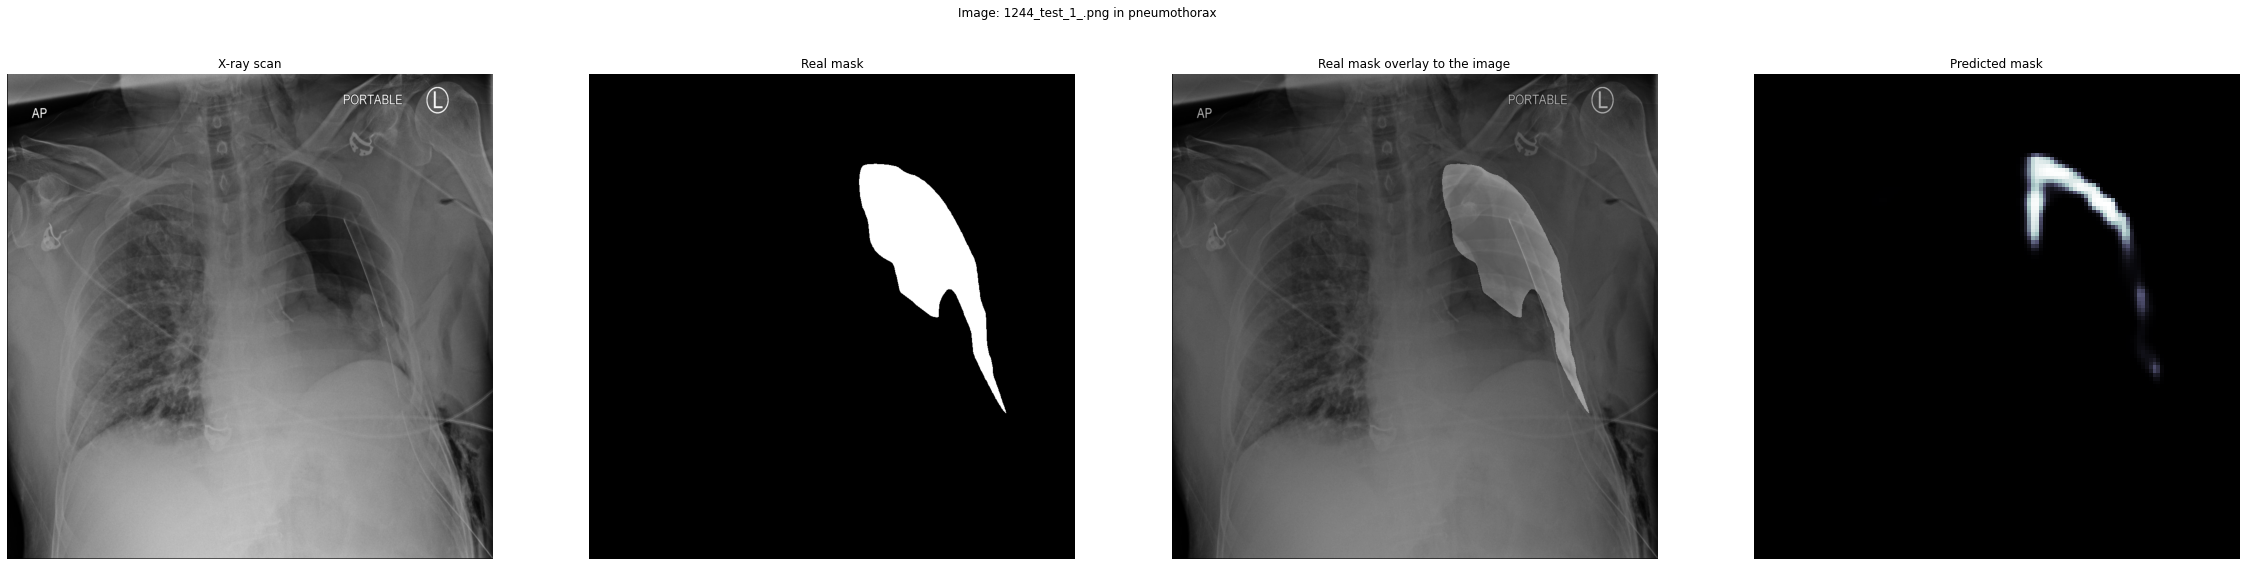

In [112]:
deeplabv3plus_predictions = deeplabv3plus_model.predict(test_set_iterator, batch_size=batch_size)
show_predictions_and_ground_thruth(test_set_iterator, deeplabv3plus_predictions)

**UNet**

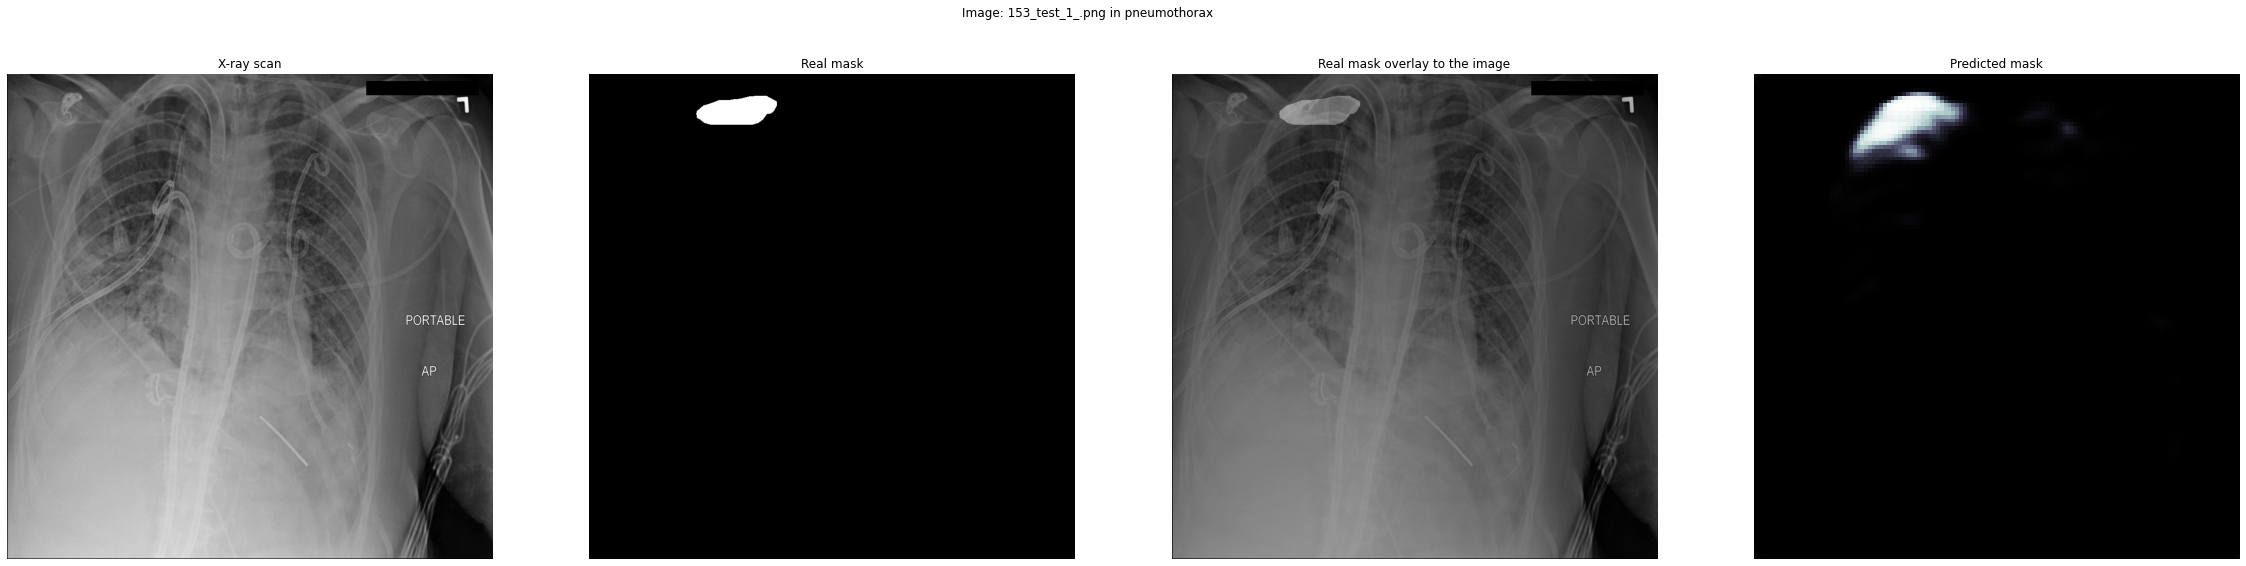

In [114]:
unet_predictions = unet_model.predict(test_set_iterator, batch_size=batch_size)
show_predictions_and_ground_thruth(test_set_iterator, unet_predictions)

## Riferimenti in letteratura

[1] A Review of Deep-Learning-Based Medical Image Segmentation Methods - https://www.mdpi.com/972888

[2] Encoder-Decoder with Atrous Separable Convolution for Semantic Image Segmentation - https://arxiv.org/abs/1802.02611

[3] Rethinking Atrous Convolution for Semantic Image Segmentation - https://arxiv.org/abs/1706.05587

[4] U-Net: Convolutional Networks for Biomedical Image Segmentation - https://arxiv.org/pdf/1505.04597.pdf